<center><h1>Mini Project 4</h1></center>
<br>
<center><font size="5">Name - Spandan Patil</font></center>
<br>
<center><font size="4">AReM Data</font></center>

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from pathlib import Path
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from scipy.stats import skew
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import label_binarize
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

Get the AReM Data Set

In [2]:
# Getting a list of all classes for which we are having datasets.
path = Path("../data/AReM")
categories = [f.name for f in path.iterdir() if f.is_dir()]

print(categories)

['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']


### (b) Splitting Data

In [3]:
# Creating a dictionary of cls having a list containing path to each of the training dataset.
train_set = defaultdict(list)

for cls in categories:
    if cls == 'bending1':
        for i in range(3, 8): 
            train_set[cls].append(f"../data/AReM/{cls}/dataset{i}.csv")
    elif cls == 'bending2':
        for i in range(3, 7): 
            train_set[cls].append(f"../data/AReM/{cls}/dataset{i}.csv")
    else:
        for i in range(4, 16):
            train_set[cls].append(f"../data/AReM/{cls}/dataset{i}.csv")

In [4]:
# Creating a dictionary of cls having a list containing path to each of the testing dataset.
test_set = defaultdict(list)

for cls in categories:
    if cls == 'bending1' or cls == 'bending2':
        for i in range(1, 3): 
            test_set[cls].append(f"../data/AReM/{cls}/dataset{i}.csv")
    else:
        for i in range(1, 4):
            test_set[cls].append(f"../data/AReM/{cls}/dataset{i}.csv")

### (c) Feature Extraction

The following Time-domain features are commonly used in time series classification include:

<ul>
    <li>Minimum: The lowest value in the time series.</li>
    <li>Maximum: The highest value in the time series.</li>
    <li>Mean: The average value of the time series.</li>
    <li>Median: The middle value when the time series is ordered.</li>
    <li>Standard deviation: A measure of the spread of values in the time series.</li>
    <li>First quartile: The 25th percentile of the ordered time series.</li>
    <li>Third quartile: The 75th percentile of the ordered time series.</li>
    <li>Variance: A measure of variability in the time series.</li>
    <li>Higher-order moments: Statistical measures beyond mean and variance.</li>
    <li>Coefficients of an AR (Autoregressive) model: Parameters that capture the dynamic behavior of the time series.</li>
    <li>Energy in specific frequency intervals: Obtained from Discrete Fourier Transform (DFT) or Discrete Wavelet Transform (DWT).</li>
</ul>

src - https://stats.stackexchange.com/questions/50807/features-for-time-series-classification

In [5]:
# Creating a list of all the columns which will be present in our new dataset having the time domain features.
cols = ['Instance']
for i in range(1, 7):
    cols.extend([f'min{i}', f'max{i}', f'mean{i}', f'median{i}', f'std{i}', f'1st_quart{i}', f'3rd_quart{i}'])

# Creating an empty dataframe with the list of columns.
extracted_df = pd.DataFrame(columns=cols)

cls_cols = cols[:]
cls_cols.append("activity")

train_df = pd.DataFrame(columns=cls_cols)
test_df = pd.DataFrame(columns=cls_cols)

# Creating a list of columns present in our dataset, to keep with reading the csv files.
inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

In [6]:
# Reading all the training datasets.

# For each of the classes in our training dictionary
for cls in train_set:
    # We get the index and path for that dataset.
    for idx, inst_path in enumerate(train_set[cls]):
        # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
        if cls == "bending2" and idx == 1:
            # Reading the csv into a dataframe.
            df = pd.read_csv(inst_path, sep=" ", skiprows=5, header=None, names=inst_cols, usecols=range(7))
        else:
            df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
        # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
        new_row = []
        new_row.append(len(extracted_df)+1)
        # We are considering only the 6 time series data, ignoring the time column.
        for i in range(1, 7):
            new_row.extend([np.min(df[df.columns[i]]), np.max(df[df.columns[i]]), np.mean(df[df.columns[i]]), np.median(df[df.columns[i]]), np.std(df[df.columns[i]]), np.percentile(df[df.columns[i]], 25), np.percentile(df[df.columns[i]], 75)])
        extracted_df.loc[len(extracted_df)] = new_row  
        cls_new_row = new_row[:]
        if cls == "bending1" or cls == "bending2":
            cls_new_row.append(1)
        else:
            cls_new_row.append(0)
        train_df.loc[len(train_df)] = cls_new_row     

In [7]:
# Reading all the testing datasets.

# For each of the classes in our testing dictionary
for cls in test_set:
    # We get the index and path for that dataset.
    for idx, inst_path in enumerate(test_set[cls]):
        # Reading the csv into a dataframe.
        df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
         # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
        new_row = []
        new_row.append(len(extracted_df)+1)
        # We are considering only the 6 time series data, ignoring the time column.
        for i in range(1, 7):
            new_row.extend([np.min(df[df.columns[i]]), np.max(df[df.columns[i]]), np.mean(df[df.columns[i]]), np.median(df[df.columns[i]]), np.std(df[df.columns[i]]), np.percentile(df[df.columns[i]], 25), np.percentile(df[df.columns[i]], 75)])
        extracted_df.loc[len(extracted_df)] = new_row    
        cls_new_row = new_row[:]
        if cls == "bending1" or cls == "bending2":
            cls_new_row.append(1)
        else:
            cls_new_row.append(0)
        test_df.loc[len(test_df)] = cls_new_row      

In [8]:
# As we can see we have our new dataset having time domain features for each of the 6 time series.
extracted_df.head()

Instance   min1   max1      mean1  median1      std1  1st_quart1  \
0       1.0  35.00  47.40  43.954500    44.33  1.557210       43.00   
1       2.0  33.00  47.75  42.179812    43.50  3.666840       39.15   
2       3.0  33.00  45.75  41.678063    41.75  2.241152       41.33   
3       4.0  37.00  48.00  43.454958    43.25  1.384653       42.50   
4       5.0  36.25  48.00  43.969125    44.50  1.616677       43.31   

   3rd_quart1  min2  max2  ...      std5  1st_quart5  3rd_quart5  min6  max6  \
0       45.00   0.0  1.70  ...  1.997520     35.3625       36.50   0.0  1.79   
1       45.00   0.0  3.00  ...  3.845436     30.4575       36.33   0.0  2.18   
2       42.75   0.0  2.83  ...  2.408514     28.4575       31.25   0.0  1.79   
3       45.00   0.0  1.58  ...  2.486268     22.2500       24.00   0.0  5.26   
4       44.67   0.0  1.50  ...  3.314843     20.5000       23.75   0.0  2.96   

      mean6  median6      std6  1st_quart6  3rd_quart6  
0  0.493292     0.43  0.512971        0.00        0.94  
1  0.613521     0.50  0.523771        0.00        1.00  
2  0.383292     0.43  0.388759        0.00        0.50  
3  0.679646     0.50  0.621885        0.43        0.87  
4  0.555312     0.49  0.487318        0.00        0.83  

[5 rows x 43 columns]

In [9]:
# Here is the function to calculate the confidence interval for each of the time domain features.
def cal_ci(data, ci=90):
    data = np.array(data).flatten()
    res = bs.bootstrap(data, stat_func=bs_stats.std, alpha=(100-ci)/100)
    return res.lower_bound, res.upper_bound, res.value

# Here we are computing the confidence intervals for each of the time domain feature
ci_intervals = {col: cal_ci(extracted_df[col]) for col in extracted_df.columns[1:]}

# Creating a dataframe to display our results.
df_ci = pd.DataFrame(ci_intervals, index=['Lower Bound', 'Upper Bound', 'Standard Deviation']).T
df_ci["interval_width"] = df_ci["Upper Bound"] - df_ci["Lower Bound"]
df_ci

Lower Bound  Upper Bound  Standard Deviation  interval_width
min1           8.324985    10.826730            9.515445        2.501745
max1           3.466714     5.416904            4.369322        1.950190
mean1          4.770800     5.936214            5.305314        1.165414
median1        4.856938     6.053848            5.409056        1.196910
std1           1.582424     1.961153            1.760219        0.378729
1st_quart1     5.620737     6.700806            6.118526        1.080069
3rd_quart1     4.433085     5.907829            5.109643        1.474744
min2           0.000000     0.000000            0.000000        0.000000
max2           4.692130     5.466655            5.033882        0.774526
mean2          1.430653     1.744162            1.565194        0.313509
median2        1.273747     1.574676            1.404197        0.300929
std2           0.819783     0.959314            0.878152        0.139531
1st_quart2     0.854328     1.058217            0.940994        0.203889
3rd_quart2     1.943831     2.347906            2.113157        0.404075
min3           2.795431     3.140020            2.939616        0.344589
max3           4.260624     5.534620            4.847358        1.273997
mean3          3.509028     4.577772            3.985540        1.068744
median3        3.519966     4.616961            4.013397        1.096995
std3           0.767300     1.123582            0.940335        0.356282
1st_quart3     3.715731     4.789165            4.196608        1.073434
3rd_quart3     3.626539     4.767493            4.147858        1.140955
min4           0.000000     0.000000            0.000000        0.000000
max4           1.993138     2.378239            2.171183        0.385101
mean4          1.103788     1.249122            1.159470        0.145334
median4        1.082783     1.228415            1.139058        0.145632
std4           0.427155     0.491829            0.455156        0.064674
1st_quart4     0.792278     0.907274            0.838813        0.114995
3rd_quart4     1.468657     1.665469            1.543658        0.196813
min5           4.696429     7.793168            6.089107        3.096739
max5           4.874579     6.699517            5.708524        1.824938
mean5          4.588233     6.868163            5.643253        2.279929
median5        4.705069     7.073547            5.780655        2.368478
std5           0.821112     1.230850            1.017996        0.409738
1st_quart5     4.967852     7.348903            6.061727        2.381052
3rd_quart5     4.500622     6.665118            5.500200        2.164495
min6           0.013125     0.091154            0.045577        0.078029
max6           2.257878     2.771573            2.504568        0.513696
mean6          1.088229     1.242334            1.148232        0.154105
median6        1.019644     1.173730            1.080284        0.154086
std6           0.486797     0.551886            0.514132        0.065088
1st_quart6     0.705837     0.822878            0.754261        0.117042
3rd_quart6     1.437200     1.637327            1.514918        0.200127

In [10]:
# Here we are checking if each of the time domain features are rightly or leftly skewed.
skw_val = extracted_df.apply(skew)
count_p = 0
count_n = 0
for val in skw_val:
    if val > 0:
        count_p += 1
    elif val < 0:
        count_n += 1

print(count_p, count_n)

29 11


Based on my judgement i will select Mean, Standard Deviation and 3rd Quartile as the three most important time domain features. The reasoning is as follows:

<ul>
    <li> Mean : This tell us the average of the time series distribution.
    <li> Standard Deviation : This will tell us the variability and spread of the data points around the mean.
    <li> 3rd Quartile : This will tell us about the right-skewness of the distribution. We take 3rd Quartile as compared to 1st Quartile as we can see above most of our features are right skewed.
</ul>

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

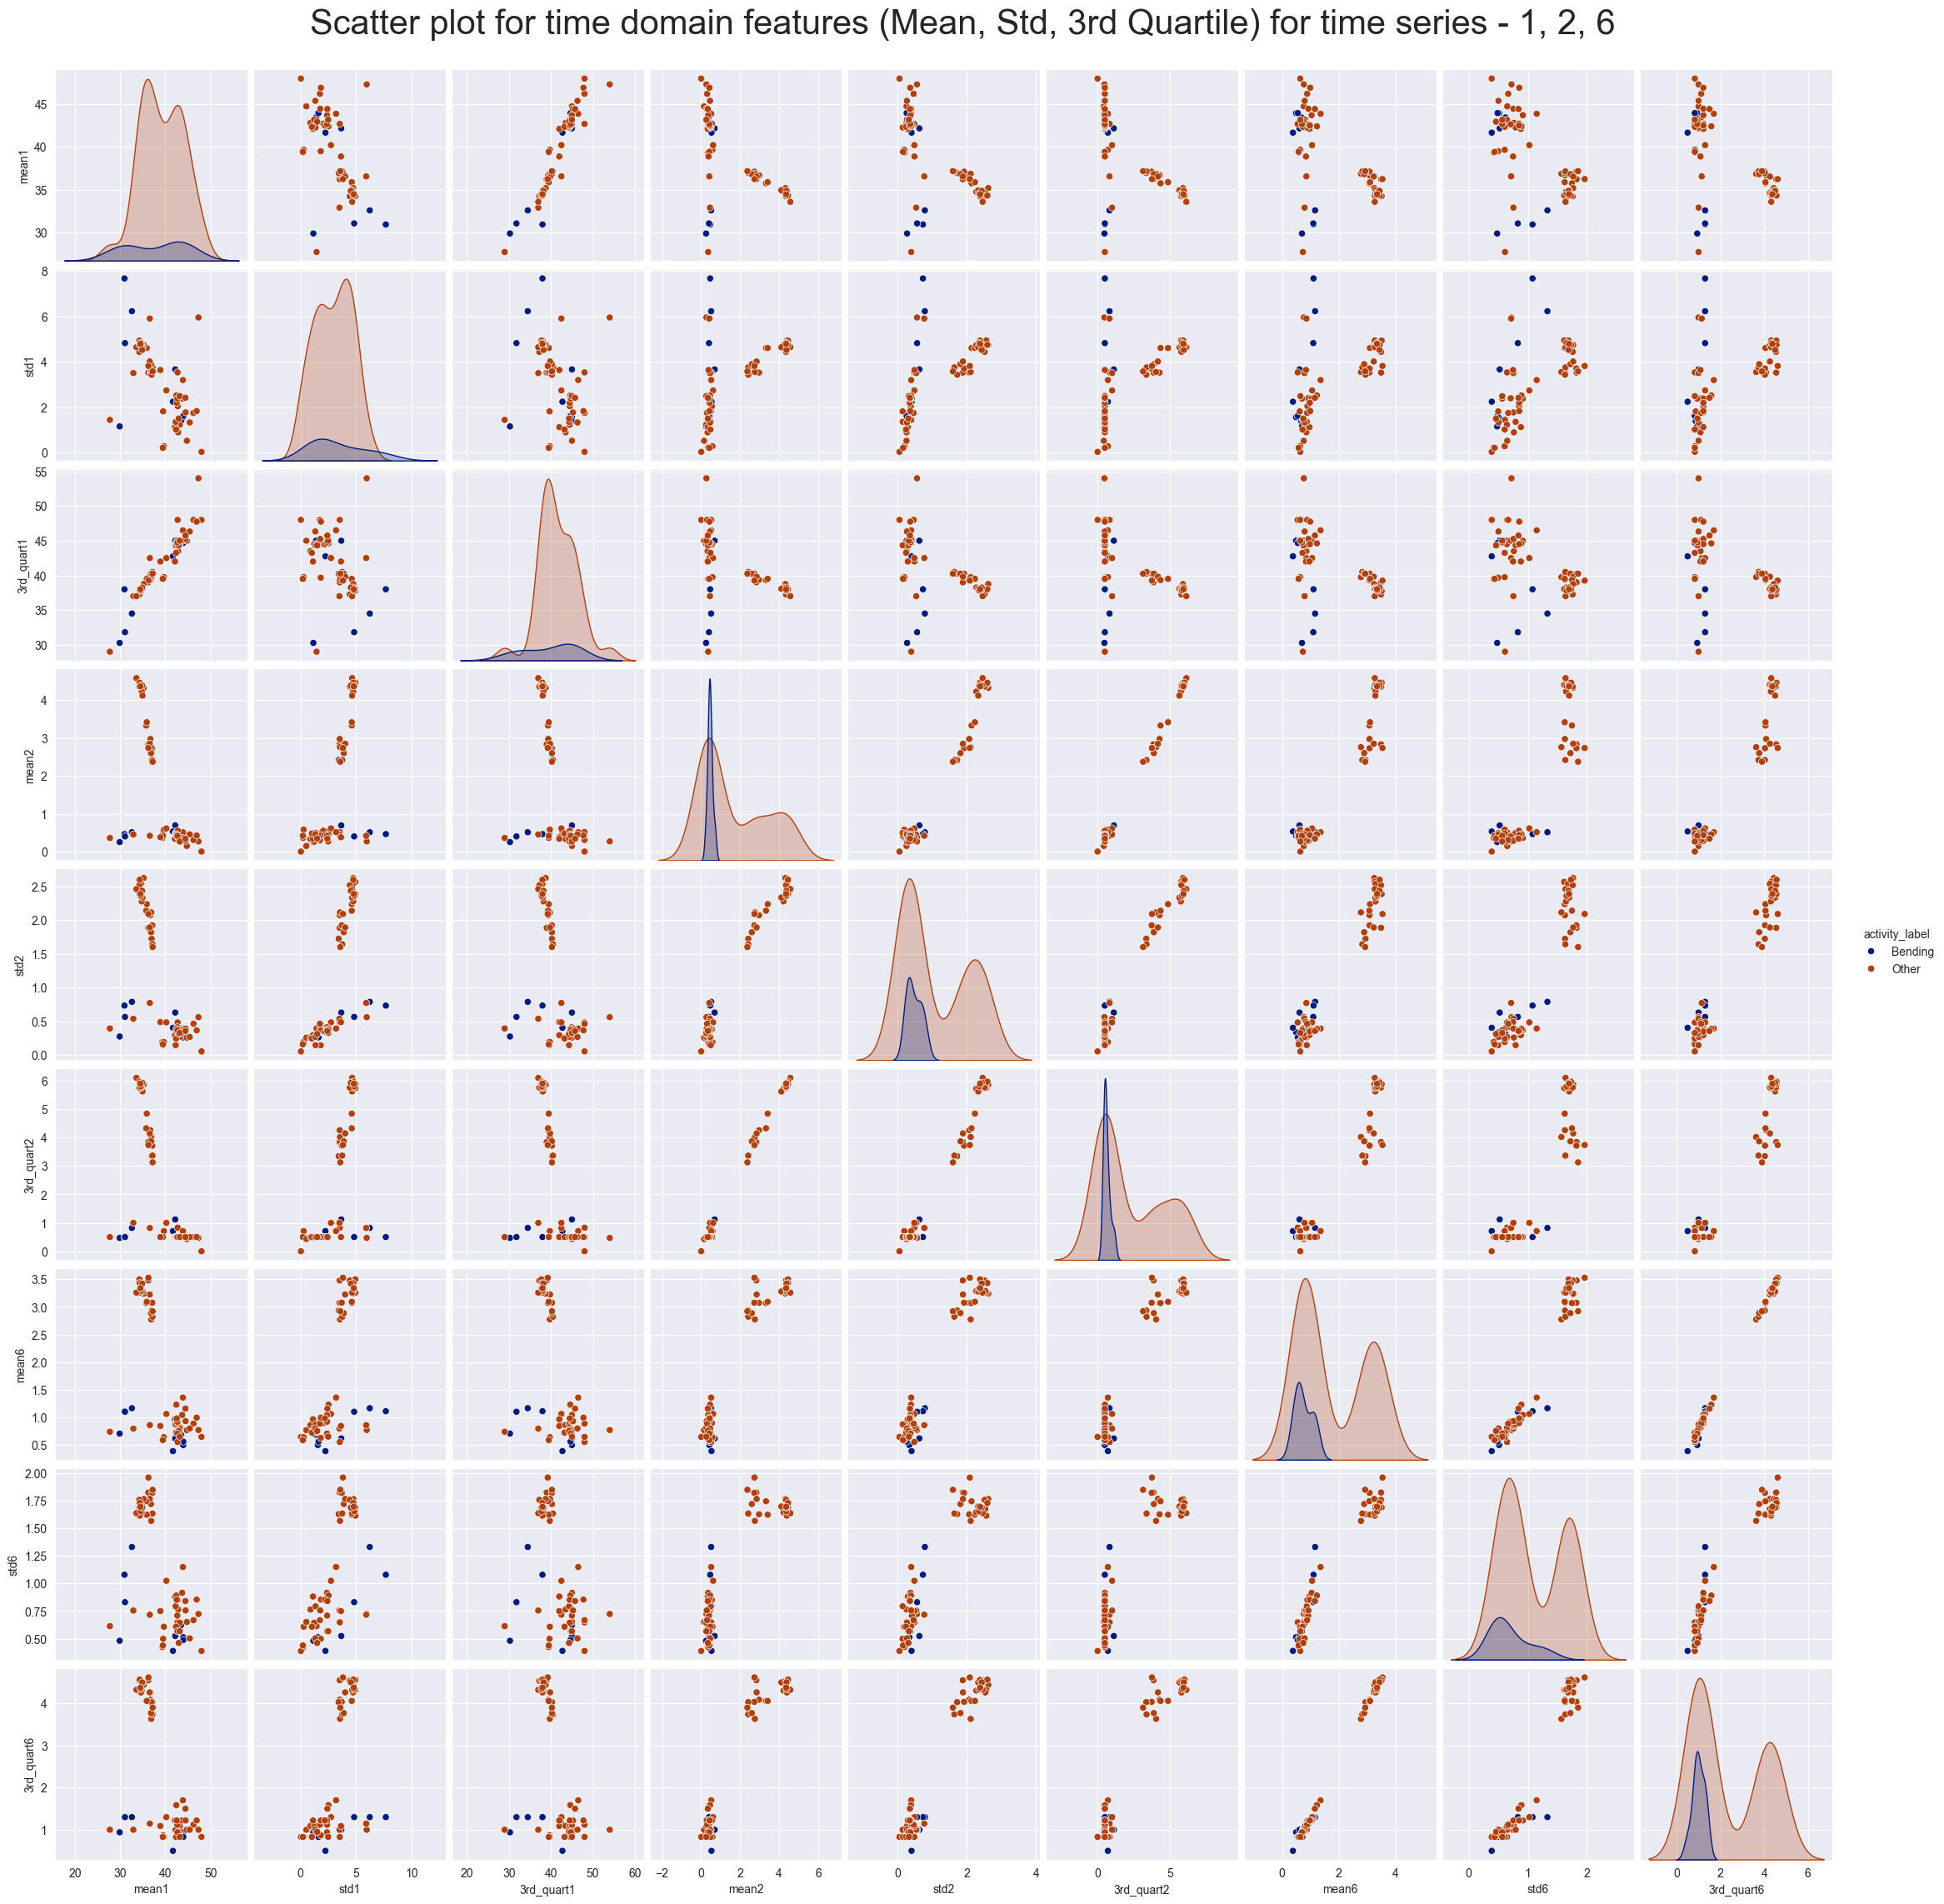

In [11]:
# Here we are creating a binary classification column in our data frame, where if the class is bending the value is 1 and else its 0.
train_df['activity_label'] = train_df['activity'].map({ 1 : 'Bending', 0: 'Other'})
# Here we are listing the time series to select.
ts_features = [1, 2, 6]
# Here we are creating the list of columns we will have in our plot.
ts_cols = ["activity_label"]
for ts in ts_features:
    ts_cols.extend([f"mean{ts}", f"std{ts}", f"3rd_quart{ts}"])

# Subsetting the dataframe for having only the selected columns
plot_df = train_df[ts_cols]

# Plotting the pairplot for all the selected columns.
sns.set_style("darkgrid")
sns.set_palette("dark")
sns.pairplot(plot_df, hue="activity_label", kind="scatter")
plt.suptitle("Scatter plot for time domain features (Mean, Std, 3rd Quartile) for time series - 1, 2, 6", fontsize=30, y=1.02)
plt.show()

#### ii. Splitted Plots

In [12]:
# In this function, we are segmenting each of the time series column into n approximately equal parts, with extra values been distributed equally starting from the part 1.
def seg_n_time_series(df, l):
    # Here we are getting the total number of records in the df.
    len = df.shape[0]
    # Here we are getting the segment size for each column part and the count of extra values to be distributed.
    seg_size, rem = divmod(len, l)

    seg_df = []

    for idx in range(l):
        # Here we are adding the extra value to each of the starting segements, till all the extra values are assigned.
        extra_val = 1 if i < rem else 0
        start_idx = idx * seg_size + min(idx, rem)
        end_idx = start_idx + seg_size + extra_val
        
        # Here we are getting the segment from the dataframe and resetting their indices.
        seg = df.iloc[start_idx:end_idx].reset_index(drop=True)
        # Here we are renaming the segments for each columns
        seg.columns = [f"{col}_seg{i+1}" for col in df.columns]
        # Appending the segments to final list.
        seg_df.append(seg)

    # Combining the segments and returning a dataframe.
    return pd.concat(seg_df, axis=1)

In [13]:
# Here we are setting the number of segements l value.
l = 2

# Creating a list of all the columns which will be present in our new dataset having the time domain features.
cols = ['Instance']
for i in range(1, 7):
    for j in range(1, l+1):
        cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])

# Adding the label column
cols.append("activity")

# Creating the our new dataframe.
train_s2_df = pd.DataFrame(columns=cols)

# Creating a list of columns present in our dataset, to keep with reading the csv files.
inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

In [14]:
# Reading all the training datasets.

# For each of the classes in our training dictionary
for cls in train_set:
    # We get the index and path for that dataset.
    for idx, inst_path in enumerate(train_set[cls]):
        # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
        if cls == "bending2" and idx == 1:
            # Reading the csv into a dataframe.
            df = pd.read_csv(inst_path, sep=" ", skiprows=5, header=None, names=inst_cols, usecols=range(7))
        else:
            df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
        
        # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
        new_df = seg_n_time_series(df[df.columns[1:]], l)
        # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
        new_row = []
        new_row.append(len(train_s2_df)+1)
        # We are considering all the time series segment columns.
        for i in range(len(new_df.columns)):
            new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
        # Adding a binary classification label for bending or not bending.
        if cls == "bending1" or cls == "bending2":
            new_row.append(1)
        else:
            new_row.append(0)
        # Adding the new record to our dataframe.
        train_s2_df.loc[len(train_s2_df)] = new_row

In [15]:
train_s2_df.head()

Instance  min1_1  max1_1    mean1_1  median1_1    std1_1  1st_quart1_1  \
0       1.0   35.00   47.40  43.954500      44.33  1.557210         43.00   
1       2.0   33.00   47.75  42.179812      43.50  3.666840         39.15   
2       3.0   33.00   45.75  41.678063      41.75  2.241152         41.33   
3       4.0   37.00   48.00  43.454958      43.25  1.384653         42.50   
4       5.0   36.25   48.00  43.969125      44.50  1.616677         43.31   

   3rd_quart1_1  min1_2  max1_2  ...  1st_quart6_1  3rd_quart6_1  min6_2  \
0         45.00     0.0    1.70  ...       35.3625         36.50     0.0   
1         45.00     0.0    3.00  ...       30.4575         36.33     0.0   
2         42.75     0.0    2.83  ...       28.4575         31.25     0.0   
3         45.00     0.0    1.58  ...       22.2500         24.00     0.0   
4         44.67     0.0    1.50  ...       20.5000         23.75     0.0   

   max6_2   mean6_2  median6_2    std6_2  1st_quart6_2  3rd_quart6_2  activity  
0    1.79  0.493292       0.43  0.512971          0.00          0.94       1.0  
1    2.18  0.613521       0.50  0.523771          0.00          1.00       1.0  
2    1.79  0.383292       0.43  0.388759          0.00          0.50       1.0  
3    5.26  0.679646       0.50  0.621885          0.43          0.87       1.0  
4    2.96  0.555312       0.49  0.487318          0.00          0.83       1.0  

[5 rows x 86 columns]

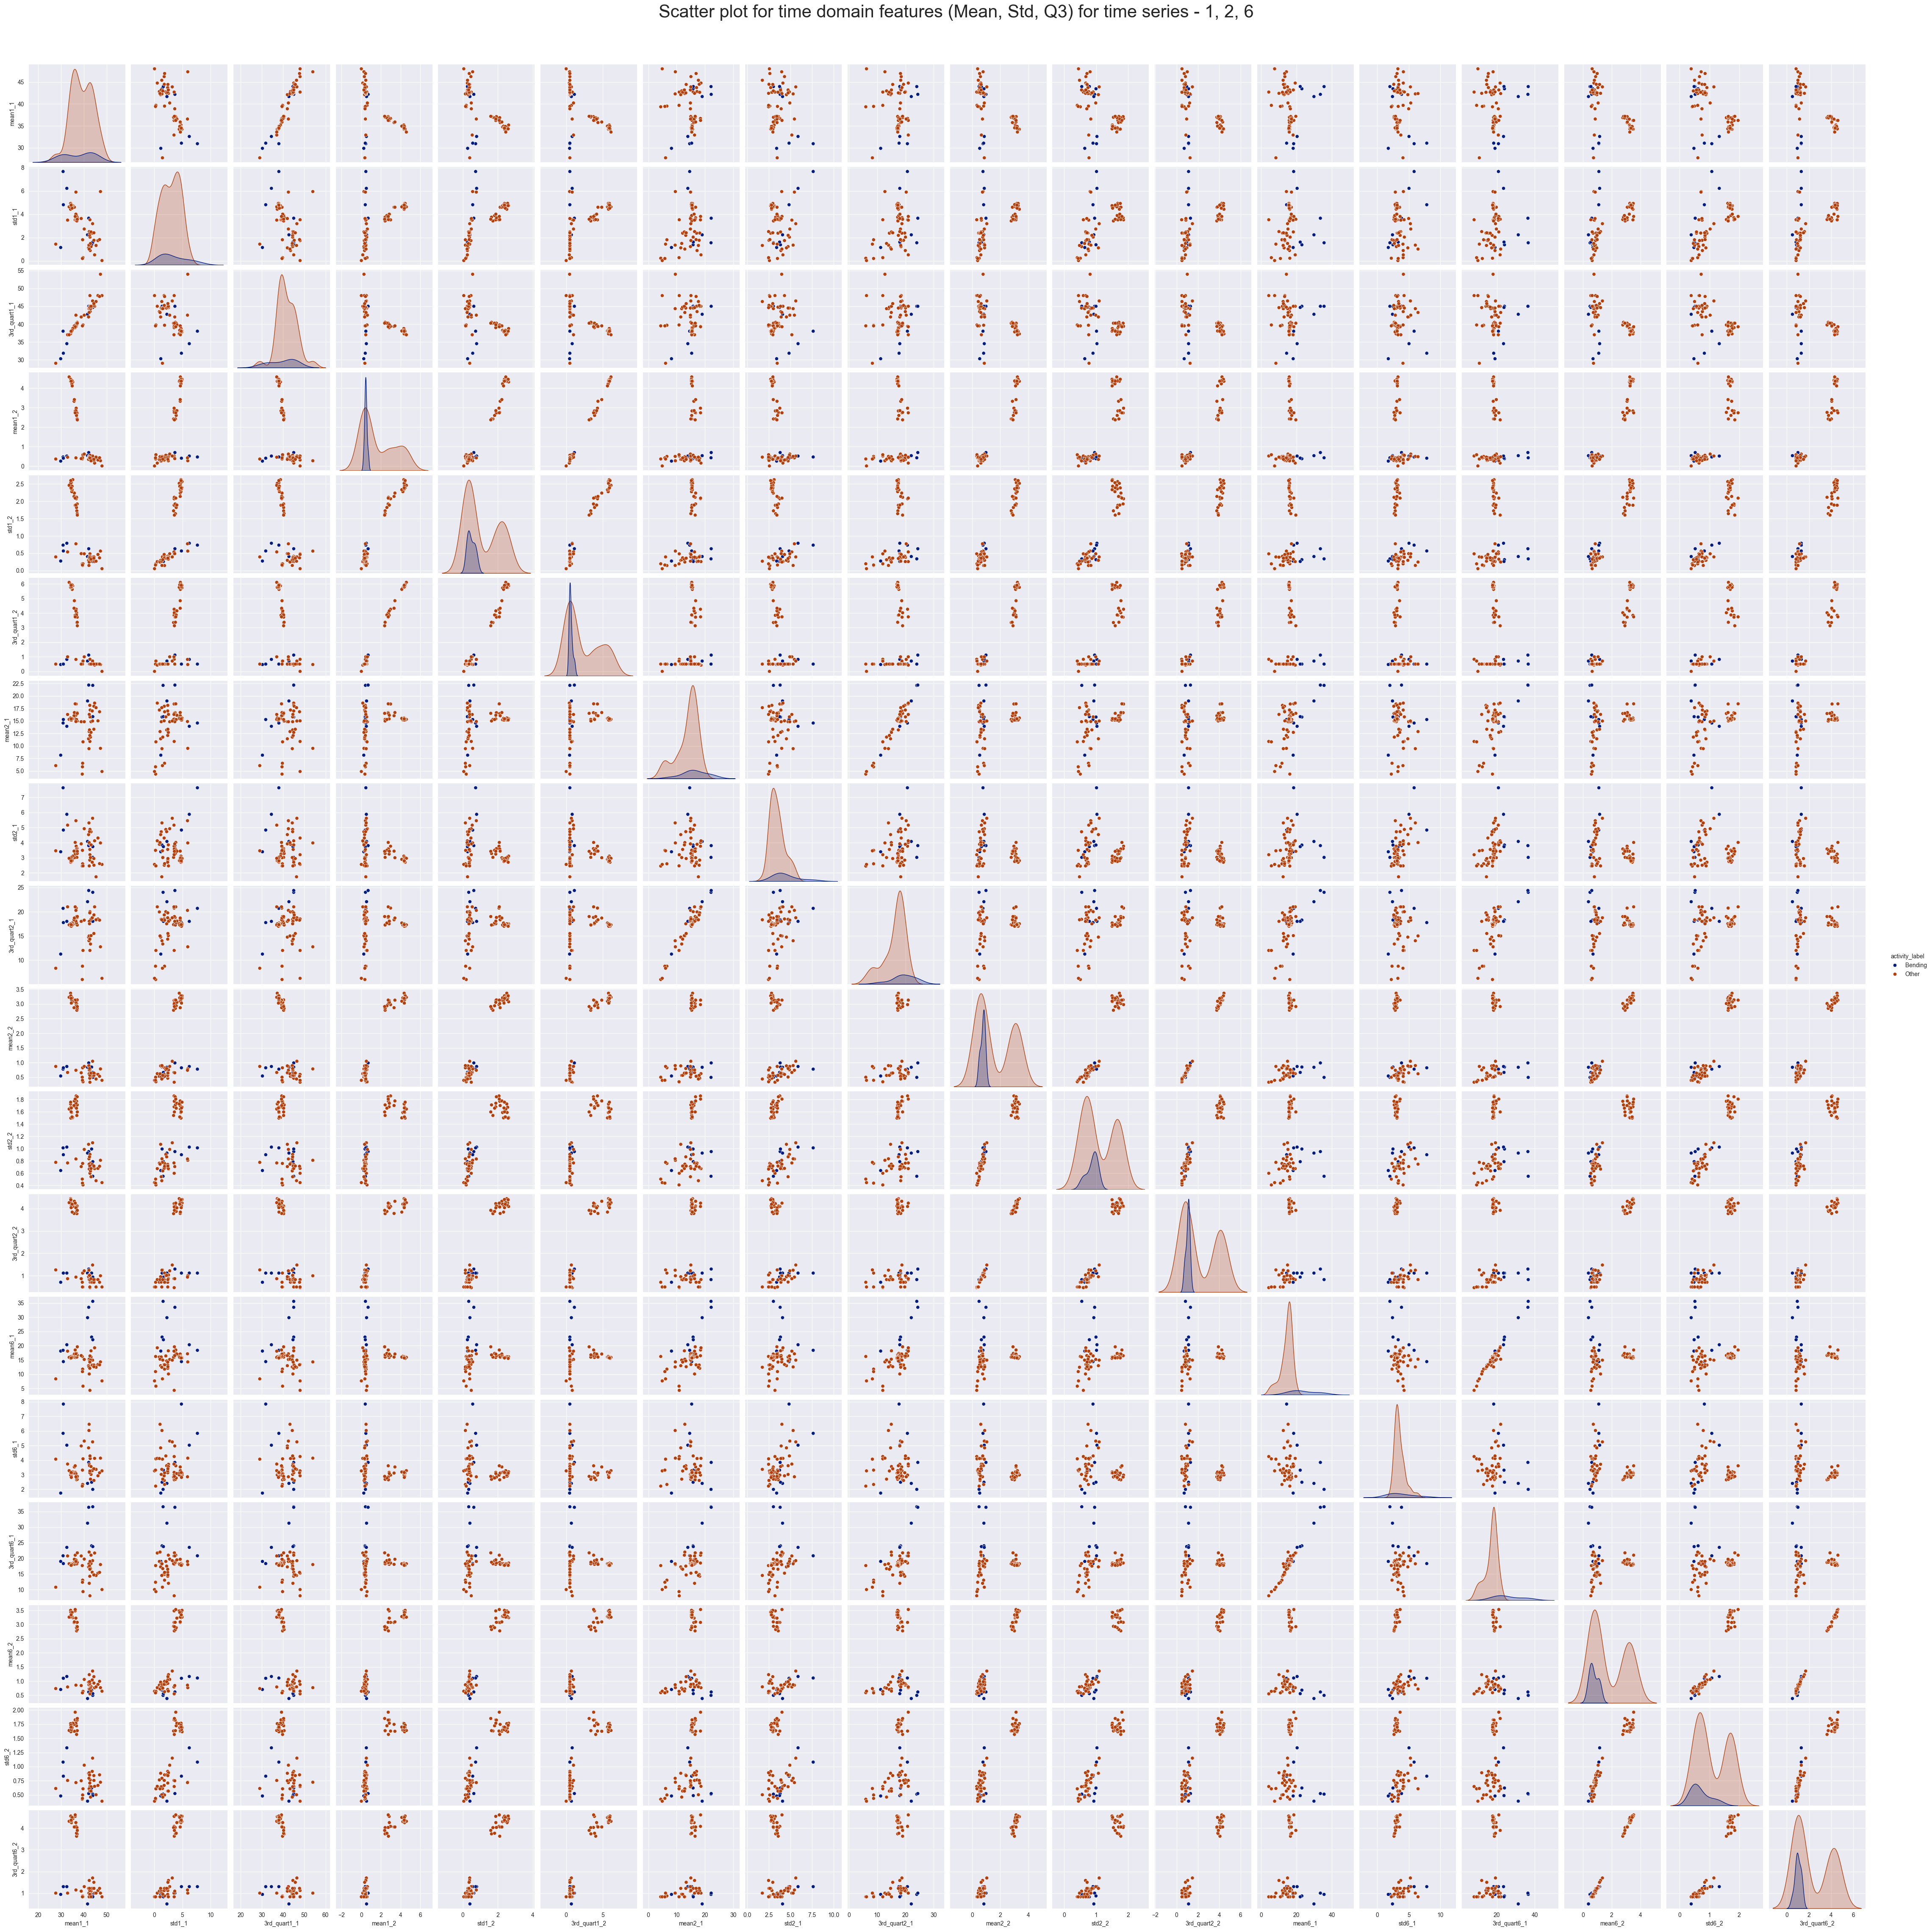

In [16]:
# Here we are creating a binary classification column in our data frame, where if the class is bending the value is 1 and else its 0.
train_s2_df['activity_label'] = train_s2_df['activity'].map({ 1 : 'Bending', 0: 'Other'})
# Here we are listing the time series to select.
ts_features = [1, 2, 6]
# Here we are creating the list of columns we will have in our plot.
ts_cols = ["activity_label"]
for ts in ts_features:
    for i in range(1, l+1):
        ts_cols.extend([f"mean{ts}_{i}", f"std{ts}_{i}", f"3rd_quart{ts}_{i}"])

# Subsetting the dataframe for having only the selected columns
plot_df = train_s2_df[ts_cols]

# Plotting the pairplot for all the selected columns.
sns.set_style("darkgrid")
sns.set_palette("dark")
sns.pairplot(plot_df, hue="activity_label", kind="scatter")
plt.suptitle("Scatter plot for time domain features (Mean, Std, Q3) for time series - 1, 2, 6", fontsize=30, y=1.02)
plt.show()

Comparing the results from 2(a)i, we cannot see any significant difference.

#### iii. Time Series Segments

The Right Way to Perform Cross-Validation is as follows:

<ul>
    <li>Split the data into 5 folds before any feature selection or model training.</li>
    <li>For each fold:</li>
    <ul>
        <li>Use the training portion of the fold to perform feature selection (e.g., RFE) and train the logistic regression model.</li>
        <li>Evaluate the model on the test portion of the fold.</li>
    </ul>
    <li>This ensures that feature selection is performed independently for each fold, preventing data leakage.</li>
</ul>

The Wrong Way to Perform Cross-validation is as follows:
<ul>
<li>Perform feature selection on the entire dataset before splitting into folds.</li>
<li>This leads to data leakage because the model has already seen the test data during feature selection, resulting in overly optimistic performance estimates.</li>
</ul>

In [17]:
# Declaring the variables to store the best value of l, p, the accuracy score and model.
best_l = None
best_p = None
best_score = float("-inf")
best_model = None

# Here we are iterating over the range of 1 to 20 value of l, thus segments from 1 to 20 for each time series columns over all the iterations.
for l in range(1, 21):
    
    # Creating a list of all the columns which will be present in our new dataset having the time domain features.
    cols = ['Instance']
    for i in range(1, 7):
        for j in range(1, l+1):
            cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])
    # Adding the class binary label columns.
    cols.append("activity")

    # Creating a new dataframe.
    train_sl_df = pd.DataFrame(columns=cols)

    # Creating a list of columns present in our dataset, to keep with reading the csv files.
    inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

    # Reading all the training datasets.
    # For each of the classes in our training dictionary
    for cls in train_set:
        # We get the index and path for that dataset.
        for idx, inst_path in enumerate(train_set[cls]):
            # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
            if cls == "bending2" and idx == 1:
                # Reading the csv into a dataframe.
                df = pd.read_csv(inst_path, sep=" ", skiprows=5, header=None, names=inst_cols, usecols=range(7))
            else:
                df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
            # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
            new_df = seg_n_time_series(df[df.columns[1:]], l)
            # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
            new_row = []
            new_row.append(len(train_sl_df)+1)
            # We are considering all the time series segment columns.
            for i in range(len(new_df.columns)):
                new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
            # Adding a binary classification label for bending or not bending.
            if cls == "bending1" or cls == "bending2":
                new_row.append(1)
            else:
                new_row.append(0)
            # Adding the new row to our dataframe.
            train_sl_df.loc[len(train_sl_df)] = new_row
            
            
    # Here we are creating the logistic Regression model and perform the Recursive Feature extraction with cross validation for our model and fitting it to our training dataset.
    # Here we are creating the object for logRegression
    logit_model = LogisticRegression(max_iter=1000)
    # Here we are creating the object for Recursive Feature extraction with cross validation for our logRegression model
    rfecv  = RFECV(estimator=logit_model, cv=5)
    # Here we are fitting it to our training dataset.
    rfecv.fit(train_sl_df[train_sl_df.columns[1:-1]], train_sl_df[train_sl_df.columns[-1]])
    # Getting the significant features.
    p = rfecv.n_features_
    # Calculating our accuracy score.
    score = rfecv.cv_results_['mean_test_score'].max()
    # Setting the best score seen till now with best l, p and model.
    if score >= best_score:
        best_l = l
        best_p = p
        best_score = score
        best_model = rfecv
    

In [18]:
print(f"Best l: {best_l}, Best p: {best_p}, best_score: {best_score}")

Best l: 14, Best p: 68, best_score: 1.0


#### iv. Confusion Matrix

In [19]:
#Here we are creating the training dataset for best l segment value.

# Creating a list of all the columns which will be present in our new dataset having the time domain features.
cols = ['Instance']
for i in range(1, 7):
    for j in range(1, best_l+1):
        cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])

# Adding the class binary label column.
cols.append("activity")

# Creating a new dataframe.
train_sl_df = pd.DataFrame(columns=cols)

# Creating a list of columns present in our dataset, to keep with reading the csv files.
inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

# Reading all the training datasets.

# For each of the classes in our training dictionary
for cls in train_set:
    # We get the index and path for that dataset.
    for idx, inst_path in enumerate(train_set[cls]):
        # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
        if cls == "bending2" and idx == 1:
            # Reading the csv into a dataframe.
            df = pd.read_csv(inst_path, sep=" ", skiprows=5, header=None, names=inst_cols, usecols=range(7))
        else:
            df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
        
        # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
        new_df = seg_n_time_series(df[df.columns[1:]], best_l)
        # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
        new_row = []
        new_row.append(len(train_sl_df)+1)
        # We are considering all the time series segment columns.
        for i in range(len(new_df.columns)):
            new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
        # Adding a binary classification label for bending or not bending.
        if cls == "bending1" or cls == "bending2":
            new_row.append(1)
        else:
            new_row.append(0)
        # Adding the new row to our dataframe.
        train_sl_df.loc[len(train_sl_df)] = new_row

In [20]:
# Setting the X_train and y_train columns.
X_train = train_sl_df[train_sl_df.columns[1:-1]]
y_train = train_sl_df[train_sl_df.columns[-1]]

# Here we are keeping only the selected features in X_train
X_train_sl = best_model.transform(X_train)

In [21]:
# Getting the y predections for our X train with selected features
y_pred = best_model.estimator_.predict(X_train_sl)

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[60  0]
 [ 0  9]]


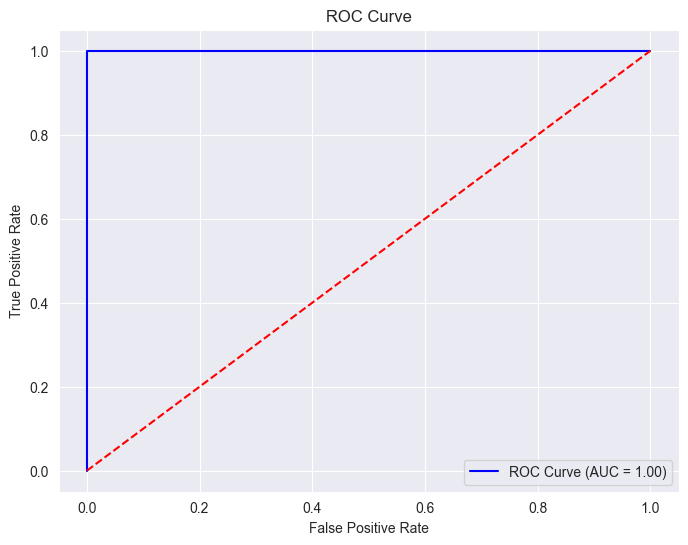

In [22]:
# Getting the y prediction probabilities for our X train with selected features
y_pred_proba = best_model.estimator_.predict_proba(X_train_sl)

# Here we are calculating the roc curve and plotting it.
fpr, tpr, _ = roc_curve(y_train, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [23]:
# Here we are getting only the selected features.
sl_features = best_model.support_
# Keeping only the selected features.
X = X_train[X_train.columns[sl_features]]

# Here we are getting the summary (p_values, coefficients, etc) for our logRegression model using statmodels
X_const = sm.add_constant(X)
logit_model = sm.Logit(y_train, X_const)
result = logit_model.fit(method="bfgs")
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 22
         Function evaluations: 28
         Gradient evaluations: 28
                           Logit Regression Results                           
Dep. Variable:               activity   No. Observations:                   69
Model:                          Logit   Df Residuals:                       58
Method:                           MLE   Df Model:                           10
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                   1.000
Time:                        19:47:58   Log-Likelihood:            -0.00017825
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 6.182e-08
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.3232        

#### v. Test Classifier

In [24]:
# Here we are creating our test dataset for best l values.

# Creating a list of all the columns which will be present in our new dataset having the time domain features.
cols = ['Instance']
for i in range(1, 7):
    for j in range(1, best_l+1):
        cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])
# Adding the class binary label column.
cols.append("activity")
# Creating a new dataframe.
test_sl_df = pd.DataFrame(columns=cols)

# Creating a list of columns present in our dataset, to keep with reading the csv files.
inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

# Reading all the testing datasets.

# For each of the classes in our training dictionary
for cls in test_set:
    # We get the index and path for that dataset.
    for idx, inst_path in enumerate(test_set[cls]):
        # Reading the instance for the test dataset.
        df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
        # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
        new_df = seg_n_time_series(df[df.columns[1:]], best_l)
        # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
        new_row = []
        new_row.append(len(test_sl_df)+1)
        # We are considering all the time series segment columns.
        for i in range(len(new_df.columns)):
            new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
        # Adding a binary classification label for bending or not bending.
        if cls == "bending1" or cls == "bending2":
            new_row.append(1)
        else:
            new_row.append(0)
        # Adding the new row to our dataframe.
        test_sl_df.loc[len(test_sl_df)] = new_row

In [25]:
# Setting the X_test and y_test columns.
X_test = test_sl_df[test_sl_df.columns[1:-1]]
y_test = test_sl_df[test_sl_df.columns[-1]]

In [26]:
# Here we are keeping only the selected features in X_test
X_test_sl = best_model.transform(X_test)
y_pred = best_model.estimator_.predict(X_test_sl)

# Creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[15  0]
 [ 0  4]]


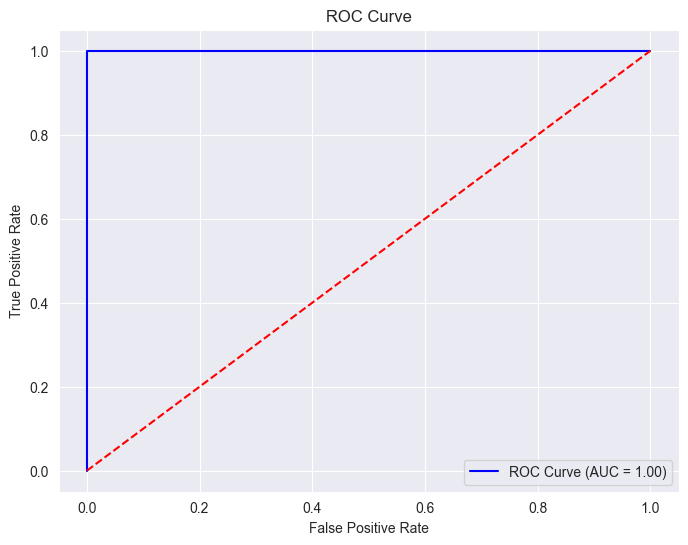

In [27]:
# Getting the y prediction probabilities for our X test with selected features
y_pred_proba = best_model.estimator_.predict_proba(X_test_sl)

# Here we are calculating the roc curve and plotting it.
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#### vi. Separation

The classes are completed separated, thus resuting in instability in calculating logistic regression parameters.

#### vii. Imbalance

From the confusion matrix we are see that there are large difference in the number of datapoints for bending class and other class, thus there definately is class imbalance.

In [28]:
# Declaring the variables to store the best value of l, p, the accuracy score and model.
best_l = None
best_p = None
best_score = float("-inf")
best_model = None

# Here we are iterating over the range of 1 to 20 value of l, thus segments from 1 to 20 for each time series columns over all the iterations.
for l in range(1, 21):
    # Creating a list of all the columns which will be present in our new dataset having the time domain features.
    cols = ['Instance']
    for i in range(1, 7):
        for j in range(1, l+1):
            cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])
    # Adding the class binary label column.
    cols.append("activity")
    # Creating a new dataframe.
    train_sl_df = pd.DataFrame(columns=cols)
    # Creating a list of columns present in our dataset, to keep with reading the csv files.
    inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

    # Reading all the training datasets.

    # For each of the classes in our training dictionary
    for cls in train_set:
        # We get the index and path for that dataset.
        for idx, inst_path in enumerate(train_set[cls]):
            # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
            if cls == "bending2" and idx == 1:
                # Reading the csv into a dataframe.
                df = pd.read_csv(inst_path, sep=" ", skiprows=5, header=None, names=inst_cols, usecols=range(7))
            else:
                df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
            # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
            new_df = seg_n_time_series(df[df.columns[1:]], l)
            # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
            new_row = []
            new_row.append(len(train_sl_df)+1)
            # We are considering all the time series segment columns.
            for i in range(len(new_df.columns)):
                new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
            # Adding a binary classification label for bending or not bending.
            if cls == "bending1" or cls == "bending2":
                new_row.append(1)
            else:
                new_row.append(0)
            # Adding the new row to our dataframe.
            train_sl_df.loc[len(train_sl_df)] = new_row
            
    # Here we are performing oversampling on the training dataset to avoid class imbalance problem.
    ros = RandomOverSampler(random_state=42)
    train_sl_df_resampled , y_train =  ros.fit_resample(train_sl_df, train_sl_df['activity'])
    X_train = train_sl_df_resampled[train_sl_df_resampled.columns[1:-1]]
    
    # Here we are creating the logistic Regression model and perform the Recursive Feature extraction with cross validation for our model and fitting it to our training dataset.
    # Here we are creating the object for logRegression
    logit_model = LogisticRegression(max_iter=1000)
    # Here we are creating the object for Recursive Feature extraction with cross validation for our logRegression model	
    rfecv  = RFECV(estimator=logit_model, cv=5)
    # Here we are fitting it to our training dataset.
    rfecv.fit(X_train, y_train)
    # Getting the significant features.
    p = rfecv.n_features_
    # Calculating our accuracy score.
    score = rfecv.cv_results_['mean_test_score'].max()
    # Setting the best score seen till now with best l, p and model.
    if score >= best_score:
        best_l = l
        best_p = p
        best_score = score
        best_model = rfecv
    

In [29]:
print(f"Best l: {best_l}, Best p: {best_p}, best_score: {best_score}")

Best l: 20, Best p: 5, best_score: 0.9916666666666668


In [30]:
#Here we are creating the training dataset for the best l

# Creating a list of all the columns which will be present in our new dataset having the time domain features.
cols = ['Instance']
for i in range(1, 7):
    for j in range(1, best_l+1):
        cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])

# Adding the class binary label column.
cols.append("activity")
# Creating a new dataframe.
train_sl_df = pd.DataFrame(columns=cols)

# Creating a list of columns present in our dataset, to keep with reading the csv files.
inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

# Reading all the training datasets.

# For each of the classes in our training dictionary
for cls in train_set:
    # We get the index and path for that dataset.
    for idx, inst_path in enumerate(train_set[cls]):
        # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
        if cls == "bending2" and idx == 1:
            # Reading the csv into a dataframe.
            df = pd.read_csv(inst_path, sep=" ", skiprows=5, header=None, names=inst_cols, usecols=range(7))
        else:
            df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
        # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
        new_df = seg_n_time_series(df[df.columns[1:]], best_l)
        # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
        new_row = []
        new_row.append(len(train_sl_df)+1)
        # We are considering all the time series segment columns.
        for i in range(len(new_df.columns)):
            new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
        # Adding a binary classification label for bending or not bending.
        if cls == "bending1" or cls == "bending2":
            new_row.append(1)
        else:
            new_row.append(0)
        # Adding the new row to our dataframe.
        train_sl_df.loc[len(train_sl_df)] = new_row

In [31]:
# Setting the X_train and y_train columns.
X_train = train_sl_df[train_sl_df.columns[1:-1]]
y_train = train_sl_df[train_sl_df.columns[-1]]

# Here we are keeping only the selected features in X_train
X_train_sl = best_model.transform(X_train)

In [32]:
# Getting the y predections for our X train with selected features
y_pred = best_model.estimator_.predict(X_train_sl)

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[60  0]
 [ 0  9]]


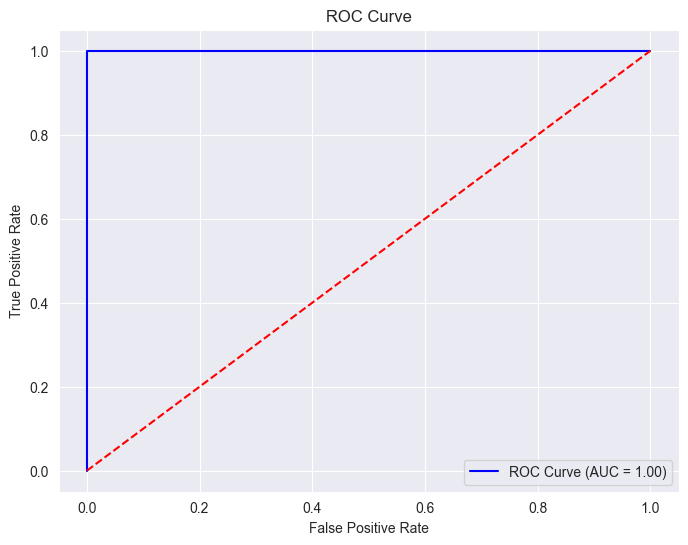

In [33]:
# Getting the y prediction probabilities for our X train with selected features
y_pred_proba = best_model.estimator_.predict_proba(X_train_sl)

# Here we are calculating the roc curve and plotting it.
fpr, tpr, _ = roc_curve(y_train, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [34]:
# Here we are getting only the selected features.
sl_features = best_model.support_
X = X_train[X_train.columns[sl_features]]

# Here we are getting the summary (p_values, coefficients, etc.) for our logRegression model using statmodels
X_const = sm.add_constant(X)
logit_model = sm.Logit(y_train, X_const)
result = logit_model.fit(method="bfgs")
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 32
         Function evaluations: 35
         Gradient evaluations: 35
                           Logit Regression Results                           
Dep. Variable:               activity   No. Observations:                   69
Model:                          Logit   Df Residuals:                       65
Method:                           MLE   Df Model:                            3
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                   1.000
Time:                        20:01:10   Log-Likelihood:            -2.7684e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 1.481e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -152.2334        nan      

In [35]:
# Here we are creating the testing dataset for our best l values.

# Creating a list of all the columns which will be present in our new dataset having the time domain features.
cols = ['Instance']
for i in range(1, 7):
    for j in range(1, best_l+1):
        cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])
# Adding the class binary label column.
cols.append("activity")
# Creating a new dataframe.
test_sl_df = pd.DataFrame(columns=cols)

# Creating a list of columns present in our dataset, to keep with reading the csv files.
inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

# Reading all the testing datasets.

# For each of the classes in our testing dictionary
for cls in test_set:
    # We get the index and path for that dataset.
    for idx, inst_path in enumerate(test_set[cls]):
        # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
        df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
        # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
        new_df = seg_n_time_series(df[df.columns[1:]], best_l)
        # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
        new_row = []
        new_row.append(len(test_sl_df)+1)
        # We are considering all the time series segment columns.
        for i in range(len(new_df.columns)):
            new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
        # Adding a binary classification label for bending or not bending.
        if cls == "bending1" or cls == "bending2":
            new_row.append(1)
        else:
            new_row.append(0)
        # Adding the new row to our dataframe.
        test_sl_df.loc[len(test_sl_df)] = new_row

In [36]:
# Setting the X_test and y_test columns.
X_test = test_sl_df[test_sl_df.columns[1:-1]]
y_test = test_sl_df[test_sl_df.columns[-1]]

# Here we are keeping only the selected features in X_train
X_test_sl = best_model.transform(X_test)

In [37]:
# Getting the y predections for our X train with selected features
y_pred = best_model.estimator_.predict(X_test_sl)

# Creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[15  0]
 [ 1  3]]


### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [38]:
# Declaring the variables to store the best value of l, p, the accuracy score and model.
best_l = None
best_score = float("-inf")
best_model = None

# Here we are iterating over the range of 1 to 20 value of l, thus segments from 1 to 20 for each time series columns over all the iterations.
for l in range(1, 21):
    
    # Creating a list of all the columns which will be present in our new dataset having the time domain features.
    cols = ['Instance']
    for i in range(1, 7):
        for j in range(1, l+1):
            cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])

    # Adding the class binary label column.
    cols.append("activity")

    # Creating a new dataframe.
    train_sl_df = pd.DataFrame(columns=cols)

    # Creating a list of columns present in our dataset, to keep with reading the csv files.
    inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

    # Reading all the training datasets.

    # For each of the classes in our training dictionary
    for cls in train_set:
        # We get the index and path for that dataset.
        for idx, inst_path in enumerate(train_set[cls]):
            # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
            if cls == "bending2" and idx == 1:
                # Reading the csv into a dataframe.
                df = pd.read_csv(inst_path, sep=" ", skiprows=5, header=None, names=inst_cols, usecols=range(7))
            else:
                df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
            # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
            new_df = seg_n_time_series(df[df.columns[1:]], l)
            # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
            new_row = []
            new_row.append(len(train_sl_df)+1)
            # We are considering all the time series segment columns.
            for i in range(len(new_df.columns)):
                new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
            # Adding a binary classification label for bending or not bending.
            if cls == "bending1" or cls == "bending2":
                new_row.append(1)
            else:
                new_row.append(0)
            # Adding the new row to our dataframe.
            train_sl_df.loc[len(train_sl_df)] = new_row
    
    # Here we are performing oversampling on the training dataset to avoid class imbalance problem.
    ros = RandomOverSampler(random_state=42)
    train_sl_df_resampled , y_train =  ros.fit_resample(train_sl_df, train_sl_df['activity'])
    X_train = train_sl_df_resampled[train_sl_df_resampled.columns[1:-1]]
    
    # Here we are creating the logistic Regression model and perform the Recursive Feature extraction with cross validation for our model and fitting it to our training dataset.
    # Here we are creating the object for logRegression
    logit_model = LogisticRegressionCV(max_iter=1000, cv=5, penalty='l1', scoring='accuracy', solver='liblinear')
    # Here we are fitting it to our training dataset.
    logit_model.fit(X_train, y_train)
    # Calculating our accuracy score.
    score = logit_model.score(X_train, y_train)
    # Setting the best score seen till now with best l and model.
    if score >= best_score:
        best_l = l
        best_score = score
        best_model = logit_model
    

In [39]:
# Here we are creating the training set for best l value.

# Creating a list of all the columns which will be present in our new dataset having the time domain features.
cols = ['Instance']
for i in range(1, 7):
    for j in range(1, best_l+1):
        cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])
# Adding the class binary label column.
cols.append("activity")
# Creating a new dataframe.
train_sl_df = pd.DataFrame(columns=cols)

# Creating a list of columns present in our dataset, to keep with reading the csv files.
inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

# Reading all the training datasets.

# For each of the classes in our training dictionary
for cls in train_set:
    # We get the index and path for that dataset.
    for idx, inst_path in enumerate(train_set[cls]):
        # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
        if cls == "bending2" and idx == 1:
            # Reading the csv into a dataframe.
            df = pd.read_csv(inst_path, sep=" ", skiprows=5, header=None, names=inst_cols, usecols=range(7))
        else:
            df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
        # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
        new_df = seg_n_time_series(df[df.columns[1:]], best_l)
        # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
        new_row = []
        new_row.append(len(train_sl_df)+1)
        # We are considering all the time series segment columns.
        for i in range(len(new_df.columns)):
            new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
        # Adding a binary classification label for bending or not bending.
        if cls == "bending1" or cls == "bending2":
            new_row.append(1)
        else:
            new_row.append(0)
        # Adding the new row to our dataframe.
        train_sl_df.loc[len(train_sl_df)] = new_row

# Setting the X_train and y_train columns.
X_train = train_sl_df[train_sl_df.columns[1:-1]]
y_train = train_sl_df[train_sl_df.columns[-1]]

In [40]:
# Getting the y predections for our X train
y_pred = best_model.predict(X_train)

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[60  0]
 [ 0  9]]


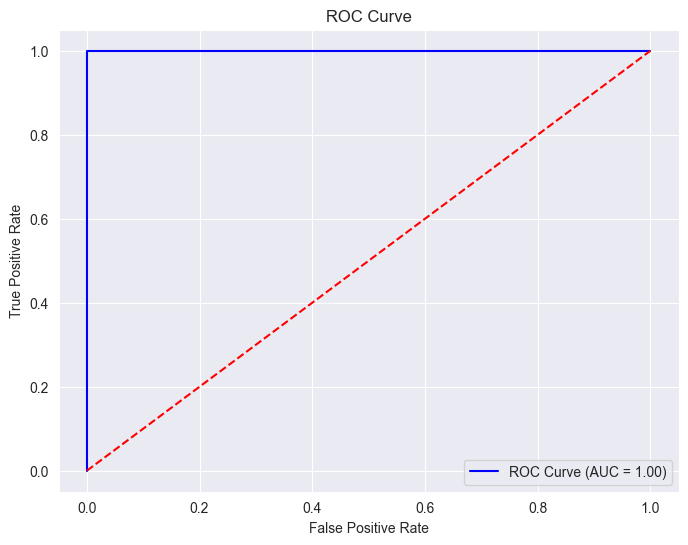

In [41]:
# Getting the y prediction probabilities for our X train
y_pred_proba = best_model.predict_proba(X_train)

# Here we are calculating the roc curve and plotting it.
fpr, tpr, _ = roc_curve(y_train, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [42]:
# Creating the testing dataset for the best l value.

# Creating a list of all the columns which will be present in our new dataset having the time domain features.
cols = ['Instance']
for i in range(1, 7):
    for j in range(1, best_l+1):
        cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])

# Adding the class binary label column.
cols.append("activity")

# Creating a new dataframe.
test_sl_df = pd.DataFrame(columns=cols)

# Creating a list of columns present in our dataset, to keep with reading the csv files.
inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

# Reading all the training datasets.

# For each of the classes in our training dictionary
for cls in test_set:
    # We get the index and path for that dataset.
    for idx, inst_path in enumerate(test_set[cls]):
        # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
        df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
        # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
        new_df = seg_n_time_series(df[df.columns[1:]], best_l)
        # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
        new_row = []
        new_row.append(len(test_sl_df)+1)
        # We are considering all the time series segment columns.
        for i in range(len(new_df.columns)):
            new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
        # Adding a binary classification label for bending or not bending.
        if cls == "bending1" or cls == "bending2":
            new_row.append(1)
        else:
            new_row.append(0)
        # Adding the new row to our dataframe.
        test_sl_df.loc[len(test_sl_df)] = new_row

In [43]:
# Setting the X_test and y_test columns.
X_test = test_sl_df[test_sl_df.columns[1:-1]]
y_test = test_sl_df[test_sl_df.columns[-1]]

In [44]:
# Getting the y predections for our X test
y_pred = best_model.predict(X_test)

# Creating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[15  0]
 [ 0  4]]


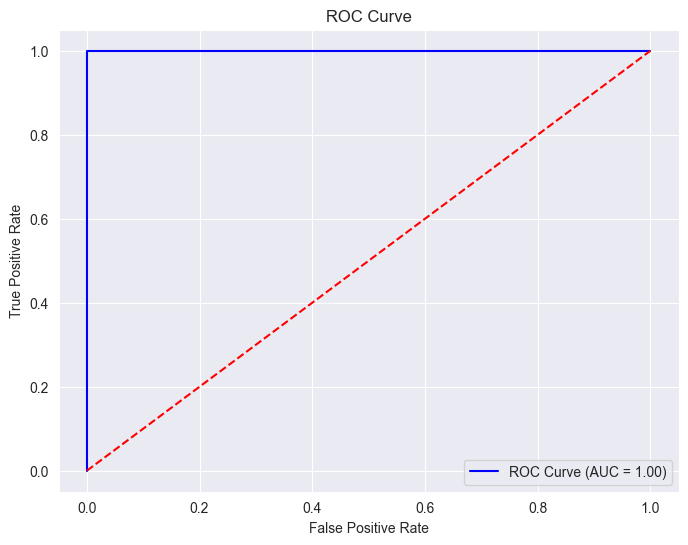

In [45]:
# Getting the y prediction probabilities for our X test
y_pred_proba = best_model.predict_proba(X_test)

# Here we are calculating the roc curve and plotting it.
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#### ii. Comparison

<ul>
    <li> L-1 penalization is easier to implement since, we dont need to manually do features selection.
    <li> As we can see in the confusion matrix the L-1 penalization perform slightly worser.
</ul>


### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [46]:
# Declaring the variables to store the best value of l, accuracy score and model.
best_l = None
best_score = float("-inf")
best_model = None

# Here we are iterating over the range of 1 to 20 value of l, thus segments from 1 to 20 for each time series columns over all the iterations.
for l in range(1, 21):
    
    # Creating a list of all the columns which will be present in our new dataset having the time domain features.
    cols = ['Instance']
    for i in range(1, 7):
        for j in range(1, l+1):
            cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])

    # Adding the class label column.
    cols.append("activity_label")

    # Creating a new dataframe.
    train_sl_df = pd.DataFrame(columns=cols)

    # Creating a list of columns present in our dataset, to keep with reading the csv files.
    inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

    # Reading all the training datasets.

    # For each of the classes in our training dictionary
    for cls in train_set:
        # We get the index and path for that dataset.
        for idx, inst_path in enumerate(train_set[cls]):
            # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
            if cls == "bending2" and idx == 1:
                # Reading the csv into a dataframe.
                df = pd.read_csv(inst_path, sep=" ", skiprows=5, header=None, names=inst_cols, usecols=range(7))
            else:
                df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
            
            # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
            new_df = seg_n_time_series(df[df.columns[1:]], l)
            # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
            new_row = []
            new_row.append(len(train_sl_df)+1)
            # We are considering all the time series segment columns.
            for i in range(len(new_df.columns)):
                new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
            # Add the class label
            new_row.append(cls)
            # Adding the new row to our dataframe.
            train_sl_df.loc[len(train_sl_df)] = new_row
    
    # Creating the label encoder object, this will convert enumerate all the class labels in the numeric labels.
    le = LabelEncoder()
    train_sl_df["activity"] = le.fit_transform(train_sl_df["activity_label"])
    train_sl_df = train_sl_df.drop("activity_label", axis=1)

    # Here we are performing oversampling on the training dataset to avoid class imbalance problem.
    ros = RandomOverSampler(random_state=42)
    train_sl_df_resampled , y_train =  ros.fit_resample(train_sl_df, train_sl_df['activity'])
    X_train = train_sl_df_resampled[train_sl_df_resampled.columns[1:-1]]

    # Here we are creating the object for logRegression
    logit_model = LogisticRegressionCV(max_iter=1000, cv=5, penalty='l1', scoring='accuracy', solver='saga', multi_class='multinomial')
    # Here we are fitting it to our training dataset.
    logit_model.fit(X_train, y_train)
    # Calculating our accuracy score.
    score = logit_model.score(X_train, y_train)
    # Setting the best score seen till now with best l and model.
    if score >= best_score:
        best_l = l
        best_score = score
        best_model = logit_model
    

In [47]:
print(f"Best l: {best_l}, best_score: {best_score}")

Best l: 20, best_score: 1.0


In [48]:
# Here we are creating the training dataset for the best l value.

# Creating a list of all the columns which will be present in our new dataset having the time domain features.
cols = ['Instance']
for i in range(1, 7):
    for j in range(1, best_l+1):
        cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])

# Adding the class label column.
cols.append("activity_label")

# Creating a new dataframe.
train_sl_df = pd.DataFrame(columns=cols)

# Creating a list of columns present in our dataset, to keep with reading the csv files.
inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

# Reading all the training datasets.

# For each of the classes in our training dictionary
for cls in train_set:
    # We get the index and path for that dataset.
    for idx, inst_path in enumerate(train_set[cls]):
        # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
        if cls == "bending2" and idx == 1:
            # Reading the csv into a dataframe.
            df = pd.read_csv(inst_path, sep=" ", skiprows=5, header=None, names=inst_cols, usecols=range(7))
        else:
            df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
        # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
        new_df = seg_n_time_series(df[df.columns[1:]], best_l)
        # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
        new_row = []
        new_row.append(len(train_sl_df)+1)
        # We are considering only the 6 time series data, ignoring the time column.
        for i in range(len(new_df.columns)):
            new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
        # Add the class label
        new_row.append(cls)
        # Adding the new row to our dataframe.
        train_sl_df.loc[len(train_sl_df)] = new_row

# Creating the label encoder object, this will convert enumerate all the class labels in the numeric labels.
le = LabelEncoder()
train_sl_df["activity"] = le.fit_transform(train_sl_df["activity_label"])
train_sl_df = train_sl_df.drop("activity_label", axis=1)

# Setting the X_train and y_train columns.
X_train = train_sl_df[train_sl_df.columns[1:-1]]
y_train = train_sl_df[train_sl_df.columns[-1]]

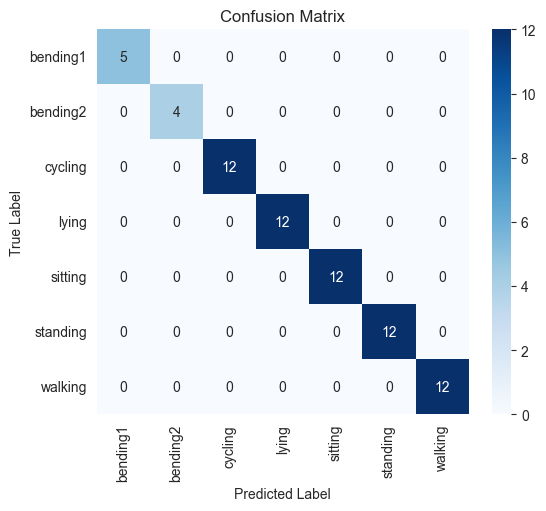

In [49]:
# Getting the y predections for our X train
y_pred = best_model.predict(X_train)

# Creating the confusion matrix and plotting it
conf_matrix = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

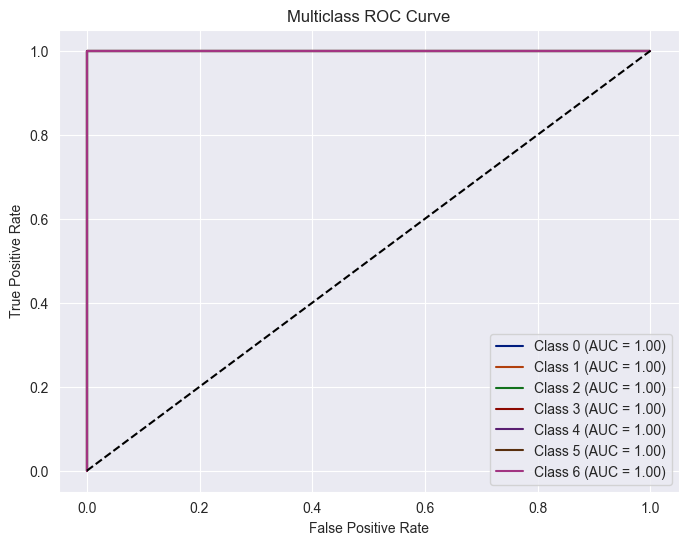

In [50]:

# Here we are binarizing the labels to (One-vs-Rest) for the ROC curve
y_train_bin = label_binarize(y_train, classes=y_train.unique())
# Getting the y prediction probabilities for our X train
y_pred_proba = best_model.predict_proba(X_train)

# Here we are calculating the roc curve and plotting it.
plt.figure(figsize=(8,6))
# Here we are calculating the roc_curve for each class
for i in range(y_train_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [51]:
# Here we are creating the tresting dataset for the best l

# Creating a list of all the columns which will be present in our new dataset having the time domain features.
cols = ['Instance']
for i in range(1, 7):
    for j in range(1, best_l+1):
        cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])

# Adding the class label column.
cols.append("activity_label")

# Creating a new dataframe.
test_sl_df = pd.DataFrame(columns=cols)

# Creating a list of columns present in our dataset, to keep with reading the csv files.
inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

# Reading all the training datasets.

# For each of the classes in our training dictionary
for cls in test_set:
    # We get the index and path for that dataset.
    for idx, inst_path in enumerate(test_set[cls]):
        # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
        df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
        # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
        new_df = seg_n_time_series(df[df.columns[1:]], best_l)
        # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
        new_row = []
        new_row.append(len(test_sl_df)+1)
       # We are considering all the time series segment columns.
        for i in range(len(new_df.columns)):
            new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
        # Add the class label
        new_row.append(cls)
        # Adding the new row to our dataframe.
        test_sl_df.loc[len(test_sl_df)] = new_row

# label encoding the test set, this will convert enumerate all the class labels in the numeric labels.
test_sl_df["activity"] = le.transform(test_sl_df["activity_label"])
test_sl_df = test_sl_df.drop("activity_label", axis=1)

# Setting the X_test and y_test columns.
X_test = test_sl_df[test_sl_df.columns[1:-1]]
y_test = test_sl_df[test_sl_df.columns[-1]]

The test accuracy is: 0.8421052631578947


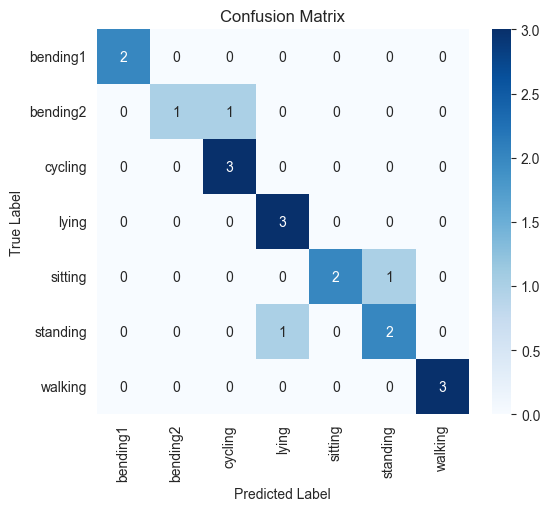

In [52]:
# Getting the y predections for our X test
y_pred = best_model.predict(X_test)

# Here we are printing the accuracy score.
print(f"The test accuracy is: {accuracy_score(y_test, y_pred)}")

# Creating the confusion matrix and plotting it
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

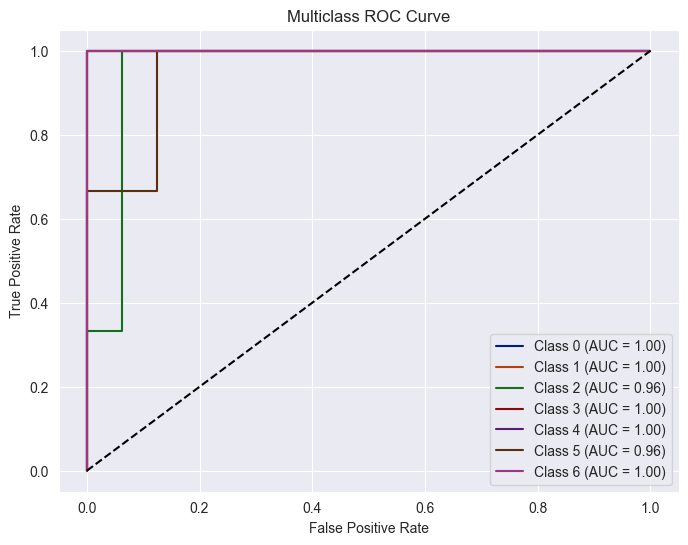

In [53]:

# Here we are binarizing the labels to (One-vs-Rest) for the ROC curve
y_test_bin = label_binarize(y_test, classes=y_test.unique())
# Getting the y prediction probabilities for our X train
y_pred_proba = best_model.predict_proba(X_test)

# Here we are calculating the roc curve and plotting it.
plt.figure(figsize=(8,6))
# Here we are calculating the roc_curve for each class
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

#### ii. Naive Bayes

##### Gaussian

In [54]:
# Declaring the variables to store the best value of l, accuracy score and model.
best_l = None
best_score = float("-inf")
best_model = None

# Here we are iterating over the range of 1 to 20 value of l, thus segments from 1 to 20 for each time series columns over all the iterations.
for l in range(1, 21):
    
    # Creating a list of all the columns which will be present in our new dataset having the time domain features.
    cols = ['Instance']
    for i in range(1, 7):
        for j in range(1, l+1):
            cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])

    # Adding the class label column.
    cols.append("activity_label")

    # Creating a new dataframe.
    train_sl_df = pd.DataFrame(columns=cols)

    # Creating a list of columns present in our dataset, to keep with reading the csv files.
    inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

    # Reading all the training datasets.

    # For each of the classes in our training dictionary
    for cls in train_set:
        # We get the index and path for that dataset.
        for idx, inst_path in enumerate(train_set[cls]):
            # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
            if cls == "bending2" and idx == 1:
                # Reading the csv into a dataframe.
                df = pd.read_csv(inst_path, sep=" ", skiprows=5, header=None, names=inst_cols, usecols=range(7))
            else:
                df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
            
            # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
            new_df = seg_n_time_series(df[df.columns[1:]], l)
            # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
            new_row = []
            new_row.append(len(train_sl_df)+1)
            # We are considering all the time series segment columns.
            for i in range(len(new_df.columns)):
                new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
            # Add the class label
            new_row.append(cls)
            # Adding the new row to our dataframe.
            train_sl_df.loc[len(train_sl_df)] = new_row
    
    # Creating the label encoder object, this will convert enumerate all the class labels in the numeric labels.
    le = LabelEncoder()
    train_sl_df["activity"] = le.fit_transform(train_sl_df["activity_label"])
    train_sl_df = train_sl_df.drop("activity_label", axis=1)

    # Here we are performing oversampling on the training dataset to avoid class imbalance problem.
    ros = RandomOverSampler(random_state=42)
    train_sl_df_resampled , y_train =  ros.fit_resample(train_sl_df, train_sl_df['activity'])
    X_train = train_sl_df_resampled[train_sl_df_resampled.columns[1:-1]]

    # Here we are creating the object for logRegression
    gNB_model = GaussianNB()
    # Here we are fitting it to our training dataset.
    gNB_model.fit(X_train, y_train)
    # Calculating our accuracy score.
    score = gNB_model.score(X_train, y_train)
    # Setting the best score seen till now with best l and model.
    if score >= best_score:
        best_l = l
        best_score = score
        best_model = gNB_model
    

In [55]:
print(f"Best l: {best_l}, best_score: {best_score}")

Best l: 20, best_score: 0.9880952380952381


In [56]:
# Here we are creating the training dataset for the best l value.

# Creating a list of all the columns which will be present in our new dataset having the time domain features.
cols = ['Instance']
for i in range(1, 7):
    for j in range(1, best_l+1):
        cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])

# Adding the class label column.
cols.append("activity_label")

# Creating a new dataframe.
train_sl_df = pd.DataFrame(columns=cols)

# Creating a list of columns present in our dataset, to keep with reading the csv files.
inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

# Reading all the training datasets.

# For each of the classes in our training dictionary
for cls in train_set:
    # We get the index and path for that dataset.
    for idx, inst_path in enumerate(train_set[cls]):
        # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
        if cls == "bending2" and idx == 1:
            # Reading the csv into a dataframe.
            df = pd.read_csv(inst_path, sep=" ", skiprows=5, header=None, names=inst_cols, usecols=range(7))
        else:
            df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
        # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
        new_df = seg_n_time_series(df[df.columns[1:]], best_l)
        # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
        new_row = []
        new_row.append(len(train_sl_df)+1)
        # We are considering only the 6 time series data, ignoring the time column.
        for i in range(len(new_df.columns)):
            new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
        # Add the class label
        new_row.append(cls)
        # Adding the new row to our dataframe.
        train_sl_df.loc[len(train_sl_df)] = new_row

# Creating the label encoder object, this will convert enumerate all the class labels in the numeric labels.
le = LabelEncoder()
train_sl_df["activity"] = le.fit_transform(train_sl_df["activity_label"])
train_sl_df = train_sl_df.drop("activity_label", axis=1)

# Setting the X_train and y_train columns.
X_train = train_sl_df[train_sl_df.columns[1:-1]]
y_train = train_sl_df[train_sl_df.columns[-1]]

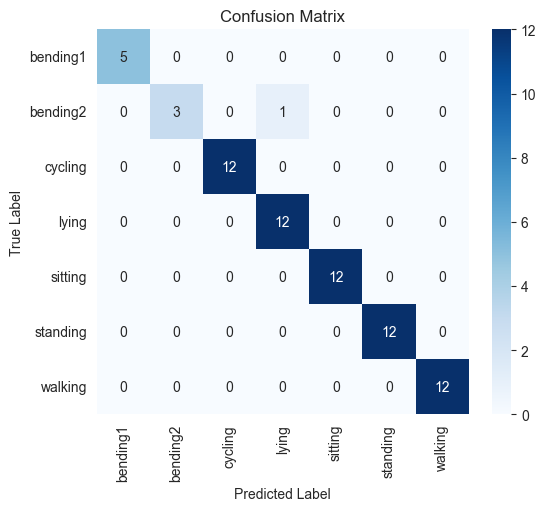

In [57]:
# Getting the y predections for our X train
y_pred = best_model.predict(X_train)

# Creating the confusion matrix and plotting it
conf_matrix = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

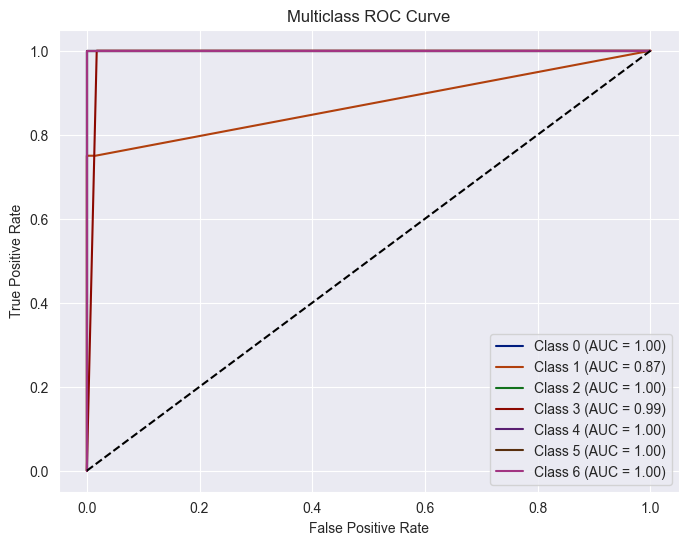

In [58]:

# Here we are binarizing the labels to (One-vs-Rest) for the ROC curve
y_train_bin = label_binarize(y_train, classes=y_train.unique())
# Getting the y prediction probabilities for our X train
y_pred_proba = best_model.predict_proba(X_train)

# Here we are calculating the roc curve and plotting it.
plt.figure(figsize=(8,6))
# Here we are calculating the roc_curve for each class
for i in range(y_train_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [59]:
# Here we are creating the tresting dataset for the best l

# Creating a list of all the columns which will be present in our new dataset having the time domain features.
cols = ['Instance']
for i in range(1, 7):
    for j in range(1, best_l+1):
        cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])

# Adding the class label column.
cols.append("activity_label")

# Creating a new dataframe.
test_sl_df = pd.DataFrame(columns=cols)

# Creating a list of columns present in our dataset, to keep with reading the csv files.
inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

# Reading all the training datasets.

# For each of the classes in our training dictionary
for cls in test_set:
    # We get the index and path for that dataset.
    for idx, inst_path in enumerate(test_set[cls]):
        # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
        df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
        # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
        new_df = seg_n_time_series(df[df.columns[1:]], best_l)
        # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
        new_row = []
        new_row.append(len(test_sl_df)+1)
       # We are considering all the time series segment columns.
        for i in range(len(new_df.columns)):
            new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
        # Add the class label
        new_row.append(cls)
        # Adding the new row to our dataframe.
        test_sl_df.loc[len(test_sl_df)] = new_row

# label encoding the test set, this will convert enumerate all the class labels in the numeric labels.
test_sl_df["activity"] = le.transform(test_sl_df["activity_label"])
test_sl_df = test_sl_df.drop("activity_label", axis=1)

# Setting the X_test and y_test columns.
X_test = test_sl_df[test_sl_df.columns[1:-1]]
y_test = test_sl_df[test_sl_df.columns[-1]]

The test accuracy is: 0.8421052631578947


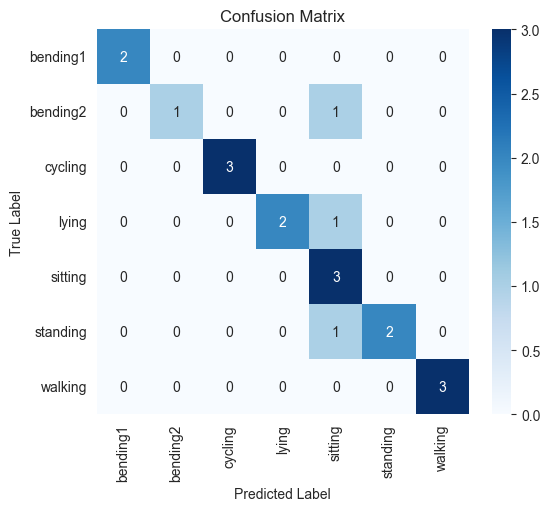

In [60]:
# Getting the y predections for our X test
y_pred = best_model.predict(X_test)

# Here we are printing the accuracy score.
print(f"The test accuracy is: {accuracy_score(y_test, y_pred)}")

# Creating the confusion matrix and plotting it
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

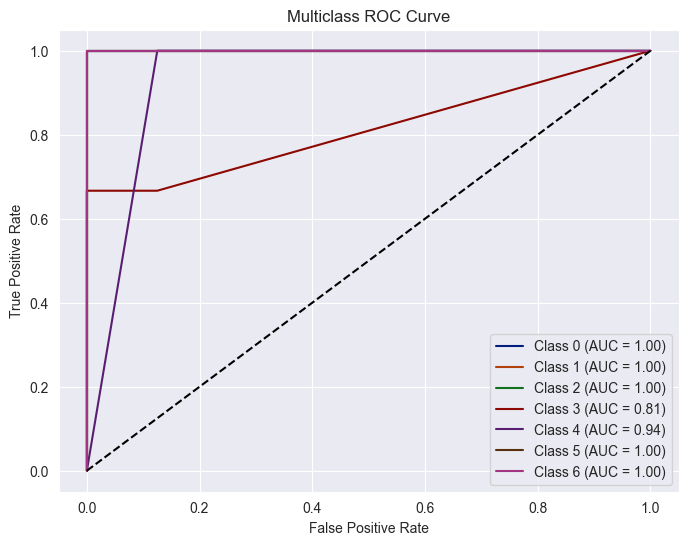

In [61]:

# Here we are binarizing the labels to (One-vs-Rest) for the ROC curve
y_test_bin = label_binarize(y_test, classes=y_test.unique())
# Getting the y prediction probabilities for our X train
y_pred_proba = best_model.predict_proba(X_test)

# Here we are calculating the roc curve and plotting it.
plt.figure(figsize=(8,6))
# Here we are calculating the roc_curve for each class
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

##### Multinomial

In [62]:
# Declaring the variables to store the best value of l, accuracy score and model.
best_l = None
best_score = float("-inf")
best_model = None

# Here we are iterating over the range of 1 to 20 value of l, thus segments from 1 to 20 for each time series columns over all the iterations.
for l in range(1, 21):
    
    # Creating a list of all the columns which will be present in our new dataset having the time domain features.
    cols = ['Instance']
    for i in range(1, 7):
        for j in range(1, l+1):
            cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])

    # Adding the class label column.
    cols.append("activity_label")

    # Creating a new dataframe.
    train_sl_df = pd.DataFrame(columns=cols)

    # Creating a list of columns present in our dataset, to keep with reading the csv files.
    inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

    # Reading all the training datasets.

    # For each of the classes in our training dictionary
    for cls in train_set:
        # We get the index and path for that dataset.
        for idx, inst_path in enumerate(train_set[cls]):
            # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
            if cls == "bending2" and idx == 1:
                # Reading the csv into a dataframe.
                df = pd.read_csv(inst_path, sep=" ", skiprows=5, header=None, names=inst_cols, usecols=range(7))
            else:
                df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
            
            # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
            new_df = seg_n_time_series(df[df.columns[1:]], l)
            # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
            new_row = []
            new_row.append(len(train_sl_df)+1)
            # We are considering all the time series segment columns.
            for i in range(len(new_df.columns)):
                new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
            # Add the class label
            new_row.append(cls)
            # Adding the new row to our dataframe.
            train_sl_df.loc[len(train_sl_df)] = new_row
    
    # Creating the label encoder object, this will convert enumerate all the class labels in the numeric labels.
    le = LabelEncoder()
    train_sl_df["activity"] = le.fit_transform(train_sl_df["activity_label"])
    train_sl_df = train_sl_df.drop("activity_label", axis=1)

    # Here we are performing oversampling on the training dataset to avoid class imbalance problem.
    ros = RandomOverSampler(random_state=42)
    train_sl_df_resampled , y_train =  ros.fit_resample(train_sl_df, train_sl_df['activity'])
    X_train = train_sl_df_resampled[train_sl_df_resampled.columns[1:-1]]

    # Here we are creating the object for logRegression
    multi_model = MultinomialNB()
    # Here we are fitting it to our training dataset.
    multi_model.fit(X_train, y_train)
    # Calculating our accuracy score.
    score = multi_model.score(X_train, y_train)
    # Setting the best score seen till now with best l and model.
    if score >= best_score:
        best_l = l
        best_score = score
        best_model = multi_model
    

In [63]:
print(f"Best l: {best_l}, best_score: {best_score}")

Best l: 18, best_score: 0.9523809523809523


In [64]:
# Here we are creating the training dataset for the best l value.

# Creating a list of all the columns which will be present in our new dataset having the time domain features.
cols = ['Instance']
for i in range(1, 7):
    for j in range(1, best_l+1):
        cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])

# Adding the class label column.
cols.append("activity_label")

# Creating a new dataframe.
train_sl_df = pd.DataFrame(columns=cols)

# Creating a list of columns present in our dataset, to keep with reading the csv files.
inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

# Reading all the training datasets.

# For each of the classes in our training dictionary
for cls in train_set:
    # We get the index and path for that dataset.
    for idx, inst_path in enumerate(train_set[cls]):
        # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
        if cls == "bending2" and idx == 1:
            # Reading the csv into a dataframe.
            df = pd.read_csv(inst_path, sep=" ", skiprows=5, header=None, names=inst_cols, usecols=range(7))
        else:
            df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
        # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
        new_df = seg_n_time_series(df[df.columns[1:]], best_l)
        # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
        new_row = []
        new_row.append(len(train_sl_df)+1)
        # We are considering only the 6 time series data, ignoring the time column.
        for i in range(len(new_df.columns)):
            new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
        # Add the class label
        new_row.append(cls)
        # Adding the new row to our dataframe.
        train_sl_df.loc[len(train_sl_df)] = new_row

# Creating the label encoder object, this will convert enumerate all the class labels in the numeric labels.
le = LabelEncoder()
train_sl_df["activity"] = le.fit_transform(train_sl_df["activity_label"])
train_sl_df = train_sl_df.drop("activity_label", axis=1)

# Setting the X_train and y_train columns.
X_train = train_sl_df[train_sl_df.columns[1:-1]]
y_train = train_sl_df[train_sl_df.columns[-1]]

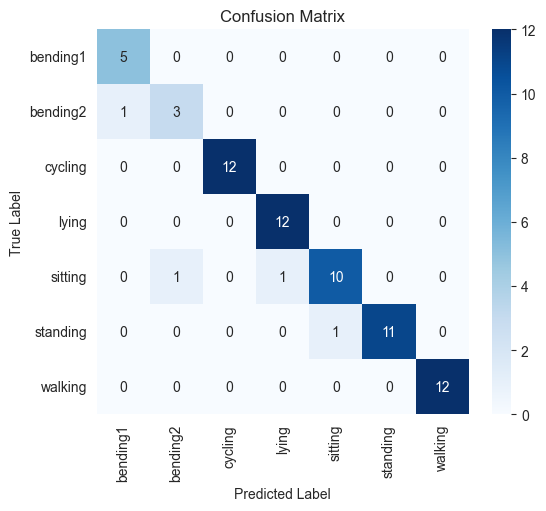

In [65]:
# Getting the y predections for our X train
y_pred = best_model.predict(X_train)

# Creating the confusion matrix and plotting it
conf_matrix = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

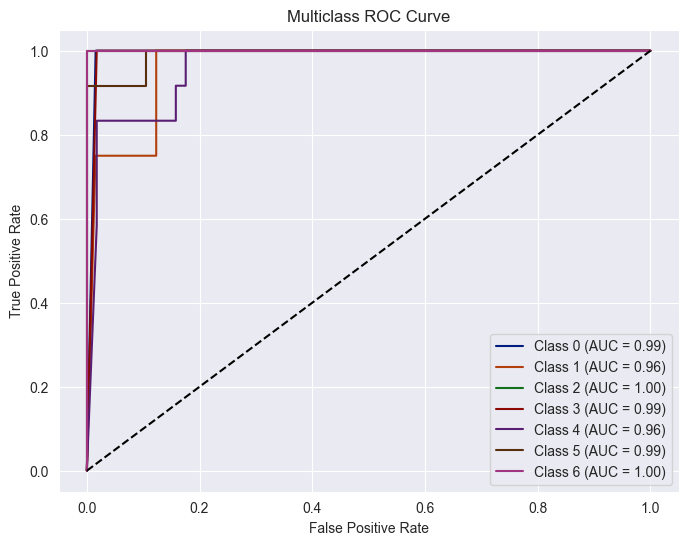

In [66]:

# Here we are binarizing the labels to (One-vs-Rest) for the ROC curve
y_train_bin = label_binarize(y_train, classes=y_train.unique())
# Getting the y prediction probabilities for our X train
y_pred_proba = best_model.predict_proba(X_train)

# Here we are calculating the roc curve and plotting it.
plt.figure(figsize=(8,6))
# Here we are calculating the roc_curve for each class
for i in range(y_train_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [67]:
# Here we are creating the tresting dataset for the best l

# Creating a list of all the columns which will be present in our new dataset having the time domain features.
cols = ['Instance']
for i in range(1, 7):
    for j in range(1, best_l+1):
        cols.extend([f'min{i}_{j}', f'max{i}_{j}', f'mean{i}_{j}', f'median{i}_{j}', f'std{i}_{j}', f'1st_quart{i}_{j}', f'3rd_quart{i}_{j}'])

# Adding the class label column.
cols.append("activity_label")

# Creating a new dataframe.
test_sl_df = pd.DataFrame(columns=cols)

# Creating a list of columns present in our dataset, to keep with reading the csv files.
inst_cols = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

# Reading all the training datasets.

# For each of the classes in our training dictionary
for cls in test_set:
    # We get the index and path for that dataset.
    for idx, inst_path in enumerate(test_set[cls]):
        # Here we are handling the special case for bending2/dataset4.csv by using space as a separator instead of comma.
        df = pd.read_csv(inst_path, skiprows=5, header=None, names=inst_cols, usecols=range(7))
        # Here we are segmenting each of the time series columns into l segments, we are ignoring the instance index column.
        new_df = seg_n_time_series(df[df.columns[1:]], best_l)
        # Here we are creating a new row which will be appended to our dataframe having all the time domain features we require from this dataset.
        new_row = []
        new_row.append(len(test_sl_df)+1)
       # We are considering all the time series segment columns.
        for i in range(len(new_df.columns)):
            new_row.extend([np.nanmin(new_df[new_df.columns[i]]), np.nanmax(new_df[new_df.columns[i]]), np.nanmean(new_df[new_df.columns[i]]), np.nanmedian(new_df[new_df.columns[i]]), np.nanstd(new_df[new_df.columns[i]]), np.nanpercentile(new_df[new_df.columns[i]], 25), np.nanpercentile(new_df[new_df.columns[i]], 75)])
        # Add the class label
        new_row.append(cls)
        # Adding the new row to our dataframe.
        test_sl_df.loc[len(test_sl_df)] = new_row

# label encoding the test set, this will convert enumerate all the class labels in the numeric labels.
test_sl_df["activity"] = le.transform(test_sl_df["activity_label"])
test_sl_df = test_sl_df.drop("activity_label", axis=1)

# Setting the X_test and y_test columns.
X_test = test_sl_df[test_sl_df.columns[1:-1]]
y_test = test_sl_df[test_sl_df.columns[-1]]

The test accuracy is: 0.8947368421052632


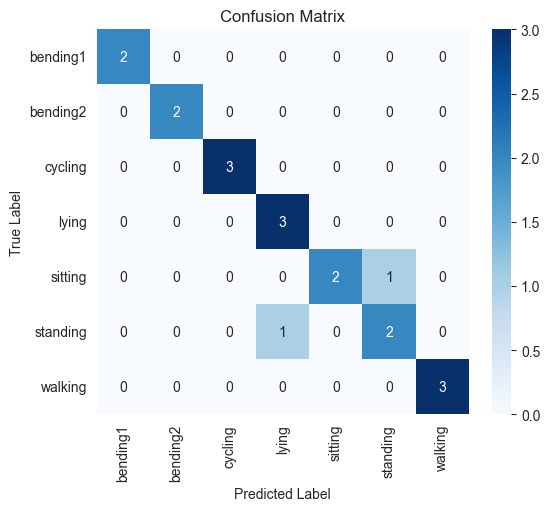

In [68]:
# Getting the y predections for our X test
y_pred = best_model.predict(X_test)

# Here we are printing the accuracy score.
print(f"The test accuracy is: {accuracy_score(y_test, y_pred)}")

# Creating the confusion matrix and plotting it
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

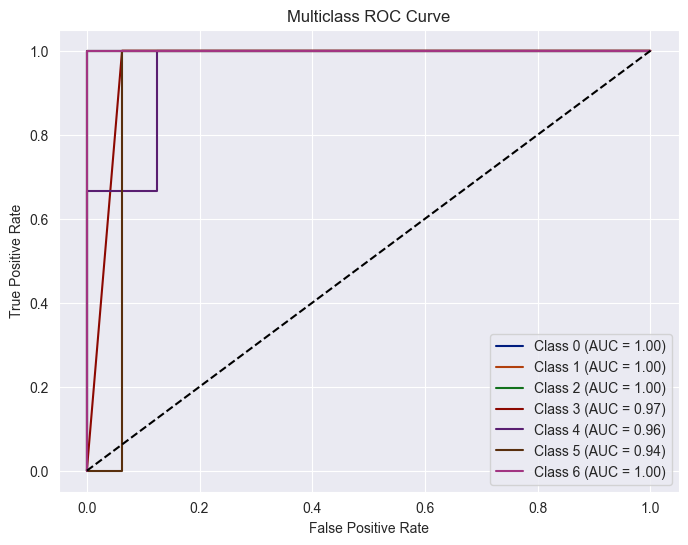

In [69]:

# Here we are binarizing the labels to (One-vs-Rest) for the ROC curve
y_test_bin = label_binarize(y_test, classes=y_test.unique())
# Getting the y prediction probabilities for our X train
y_pred_proba = best_model.predict_proba(X_test)

# Here we are calculating the roc curve and plotting it.
plt.figure(figsize=(8,6))
# Here we are calculating the roc_curve for each class
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

#### ii. Comparison

As, we can see in the above test accuracy of Logistic Regression, Naive Bayes Gaussion and Naive Bayes Multinominal, the Naive Bayes Multimonial has the highest test accuracy. Thus, the Naive Bayes Mutlinominal performances the best.

## 3. ISLR 4.8.3

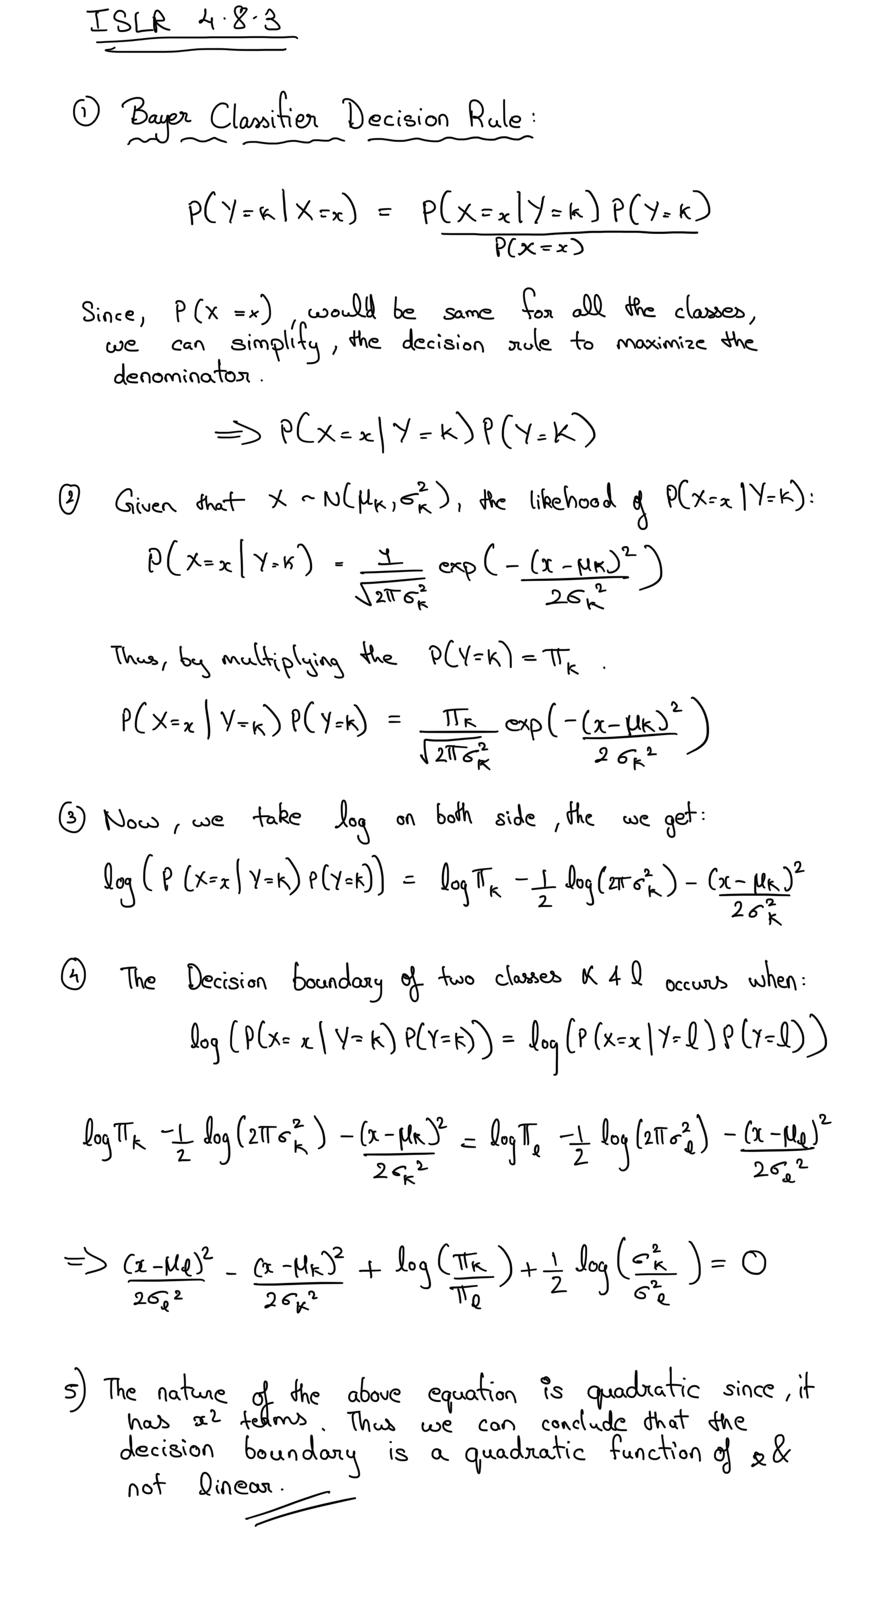

In [70]:
Image("../data/ISLR_4.8.3.jpg")

## 4. ISLR 4.8.7

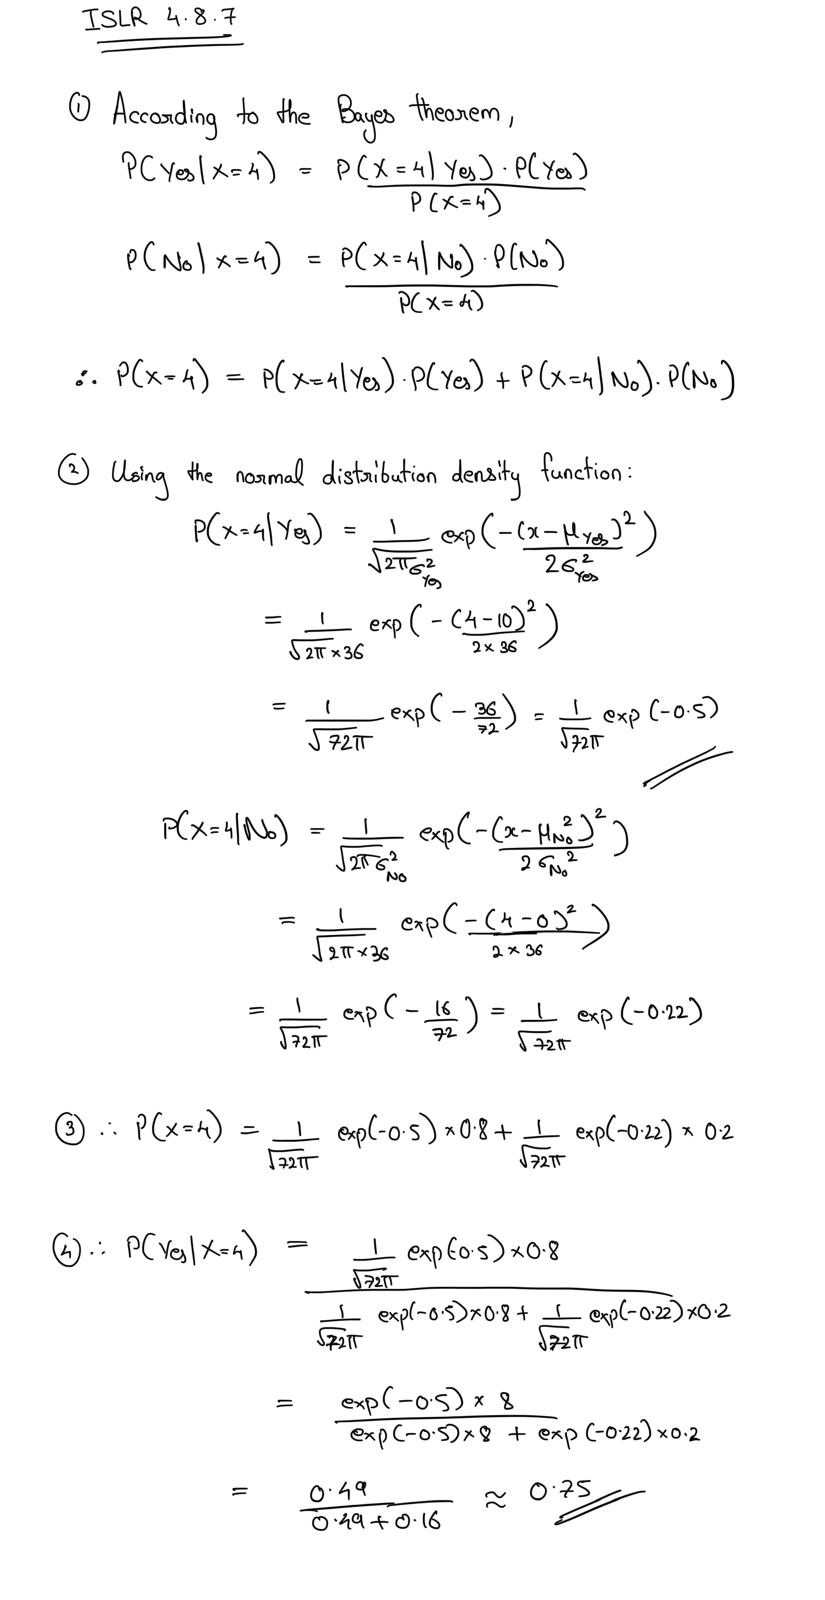

In [71]:
Image("../data/ISLR_4.8.7.jpg")

## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9